# Competition Objective is to detect fraud in transactions; 

## Data


In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target ```isFraud```.

The data is broken into two files **identity** and **transaction**, which are joined by ```TransactionID```. 

> Note: Not all transactions have corresponding identity information.

**Transaction variables**

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

**Categorical Features - Transaction**

- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Categorical Features - Identity**

- DeviceType
- DeviceInfo
- id_12 - id_38

**The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).**


# 1. Importation and memory reduction
## 1.1. Importing necessary libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go

import plotly.express as px
import plotly.tools as tls
from plotly.subplots import make_subplots

from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff


# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
import time

In [0]:
### Import data from google drive

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link1 = 'https://drive.google.com/open?id=1VLhLtqXYRNVtQbNaQr4M8TvtqVrJ6IDi'
link2 = 'https://drive.google.com/open?id=16BltOWr3AW_RYIWsHJJHDPRT5spX7h9H'
link3 = 'https://drive.google.com/open?id=18F3oYUH4AxKisji8YX0CeLaoNiIvL8K9'
link4 = 'https://drive.google.com/open?id=1JMa86BsJ2xfhgwgCQFrxmBwAHDQ4BvWi'
_, id1 = link1.split('=')
_, id2 = link2.split('=')
_, id3 = link3.split('=')
_, id4 = link4.split('=')

downloaded1 = drive.CreateFile({'id':id1}) 
downloaded1.GetContentFile('train_transaction.csv')  
downloaded2 = drive.CreateFile({'id':id2}) 
downloaded2.GetContentFile('train_identity.csv')  
downloaded3 = drive.CreateFile({'id':id3}) 
downloaded3.GetContentFile('test_transaction.csv')  
downloaded4 = drive.CreateFile({'id':id4}) 
downloaded4.GetContentFile('test_identity.csv')  

## 1.2. Importing train datasets

In [0]:
df_id = pd.read_csv("train_identity.csv")
df_trans = pd.read_csv("train_transaction.csv")
test_id = pd.read_csv('test_identity.csv')
test_trans = pd.read_csv('test_transaction.csv')

In [0]:
print(df_id.shape)
print(df_trans.shape)

(144233, 41)
(590540, 394)


## 1.3. Memory reduction

In [0]:
def resumetable(df):
    n = df.shape[0]
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values  
    summary['Missing %'] = round(summary['Missing'] / n * 100,2)
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True, object_tranform = False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)   
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    print('Lower bounded value: {:.2f}'.format(lower))
    print('Upper bounded value: {:.2f}'.format(upper))
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [0]:
## REducing memory
%%time
df_trans = reduce_mem_usage(df_trans)
df_id = reduce_mem_usage(df_id)
test_trans = reduce_mem_usage(test_trans)
test_id = reduce_mem_usage(test_id)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)
CPU times: user 2min 25s, sys: 4.34 s, total: 2min 29s
Wall time: 2min 29s


To see the output of the Resume Table, click to see the output 

#2. EDA

Transaction data 

- 0-54: Original features
- 55- : Vesta engineered rich features 

In [0]:
pd.concat([resumetable(df_trans.iloc[:,2:55]),resumetable(test_trans.iloc[:,1:54])], axis = 1)

Dataset Shape: (590540, 53)
Dataset Shape: (506691, 53)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionDT,int32,0,0.00,573349,86400,86401,86469,19.11,TransactionDT,int32,0,0.00,494686,18403224,18403263,18403310,18.90
1,TransactionAmt,float16,0,0.00,8195,68.5,29,59,8.10,TransactionAmt,float16,0,0.00,7343,31.9531,49,171,7.93
2,ProductCD,object,0,0.00,5,W,W,W,1.28,ProductCD,object,0,0.00,5,W,W,W,1.37
3,card1,int16,0,0.00,13553,13926,2755,4663,9.97,card1,int16,0,0.00,13244,10409,4272,4476,9.95
4,card2,float16,8933,1.51,500,NaN,404,490,6.32,card2,float16,8654,1.71,497,111,111,574,6.28
5,card3,float16,1565,0.27,114,150,150,150,0.68,card3,float16,3002,0.59,115,150,150,150,0.81
6,card4,object,1577,0.27,4,discover,mastercard,visa,1.09,card4,object,3086,0.61,4,visa,visa,visa,1.05
7,card5,float16,4259,0.72,119,142,102,166,2.66,card5,float16,4547,0.90,102,226,226,226,2.63
8,card6,object,1571,0.27,4,credit,credit,debit,0.82,card6,object,3007,0.59,3,debit,debit,debit,0.79
9,addr1,float16,65706,11.13,332,315,325,330,5.06,addr1,float16,65609,12.95,292,170,299,472,5.10


## 2.1. Target Distribution

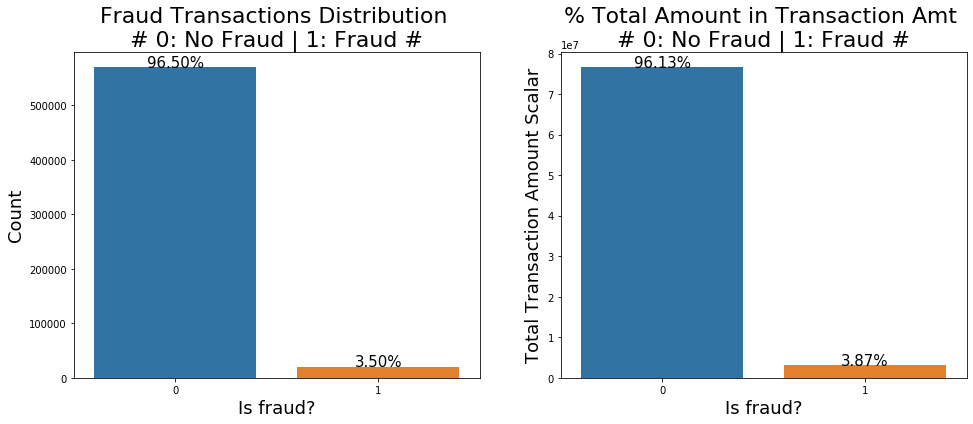

In [0]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_trans, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

We have 3.5% of Fraud transactions in our dataset. <br>I think that it would be interesting to see if the amount percentual is higher or lower than 3.5% of total. I will see it later. <br>
We have the same % when considering the Total Transactions Amount by Fraud and No Fraud. <br>
Let's explore the Transaction amount further below.

## 2.2. Transaction Amount Quantiles

Before Ploting the Transaction Amount, let's see the quantiles of Transaction Amount

In [0]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
test_trans['TransactionAmt'] = test_trans['TransactionAmt'].astype(float)

print("Training - Transaction Amounts Quantiles:")
print(df_trans['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))
print("Test - Transaction Amounts Quantiles:")
print(test_trans['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))


Training - Transaction Amounts Quantiles:
0.010       9.242188
0.025      14.500000
0.100      25.953125
0.250      43.312500
0.500      68.750000
0.750     125.000000
0.900     275.250000
0.975     648.262500
0.990    1104.000000
Name: TransactionAmt, dtype: float64
Test - Transaction Amounts Quantiles:
0.010       7.378906
0.025      11.375000
0.100      25.000000
0.250      40.000000
0.500      67.937500
0.750     125.000000
0.900     268.000000
0.975     637.000000
0.990    1104.000000
Name: TransactionAmt, dtype: float64


### 2.2.1 Ploting Transaction Amount Values Distribution

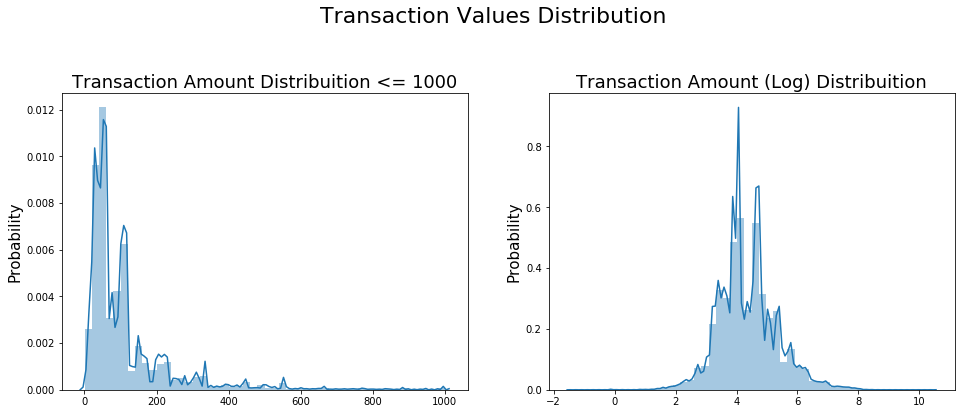

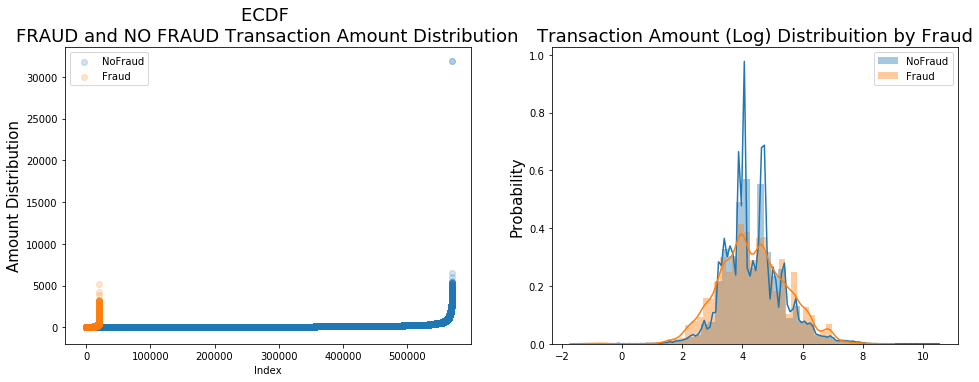

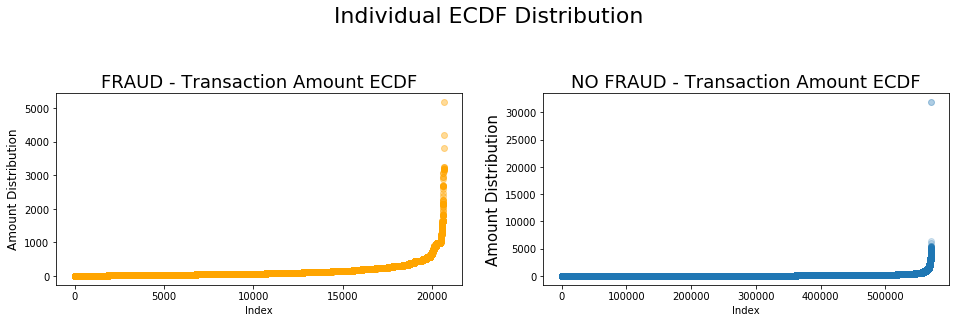

In [0]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
g = sns.distplot(df_trans[df_trans['TransactionAmt'] <= 1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(df_trans['TransactionAmt']))
g1.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))


plt.subplot(221)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values), 
                 label='Fraud', alpha=.2)
g4= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Amount Distribution", fontsize=15)
g4 = plt.legend()

plt.subplot(222)
g = sns.distplot(np.log(df_trans[df_trans['isFraud'] == 0]['TransactionAmt']), label='NoFraud')
g = sns.distplot(np.log(df_trans[df_trans['isFraud'] == 1]['TransactionAmt']), label='Fraud')
g= plt.title("Transaction Amount (Log) Distribuition by Fraud", fontsize=18)
g = plt.xlabel("")
g = plt.ylabel("Probability", fontsize=15)
g = plt.legend()

plt.figure(figsize=(16,12))

plt.subplot(321)
g = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]), 
                 np.sort(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.4, color = 'orange')
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
g1 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
g1= plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=22)

plt.show()

In the log distribution of Transaction Amount graph, the tail corresponding to the fraud transactions is heavier than the one corresponding to the non fraud.

### 2.2.2 Seeing the Quantiles of Fraud and No Fraud Transactions

In [0]:
print(pd.concat([df_trans[df_trans['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(), 
                 df_trans[df_trans['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

  Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01       6.739453     0.01       9.511875
1  0.10      18.937500     0.10      26.312500
2  0.25      35.031250     0.25      43.968750
3  0.50      75.000000     0.50      68.500000
4  0.75     161.000000     0.75     120.000000
5  0.90     335.000000     0.90     267.100000
6  0.99     994.000000     0.99    1104.000000


### 2.2.3 Transaction Amount Outliers
It's considering outlier values that are highest than 3 times the std from the mean

In [0]:
CalcOutliers(df_trans['TransactionAmt'])

Lower bounded value: -582.44
Upper bounded value: 852.50
Identified lowest outliers: 0
Identified upper outliers: 10097
Total outlier observations: 10097
Non-outlier observations: 580443
Total percentual of Outliers:  1.7395


If we consider only values between >= 0 to 852 we will avoid the outliers and has more confidence in our distribution. <br>
We have 10k rows with outliers that represents 1.74% of total rows.

In [0]:
CalcOutliers(np.log(df_trans['TransactionAmt']))

Lower bounded value: 1.50
Upper bounded value: 7.23
Identified lowest outliers: 1024
Identified upper outliers: 4300
Total outlier observations: 5324
Non-outlier observations: 585216
Total percentual of Outliers:  0.9097


if we consider the log transform of TA, the number of outliers reduces by half. 

## 2.3. ProductCD
- Distribution Products
- Distribution of Frauds by Product
- Has Difference between Transaction Amounts in Products? 

In [0]:
print('Train set:')
print(df_trans['ProductCD'].value_counts())
print('Test set:')
print(test_trans['ProductCD'].value_counts())

Train set:
W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64
Test set:
W    360987
C     69266
R     35647
H     29373
S     11418
Name: ProductCD, dtype: int64


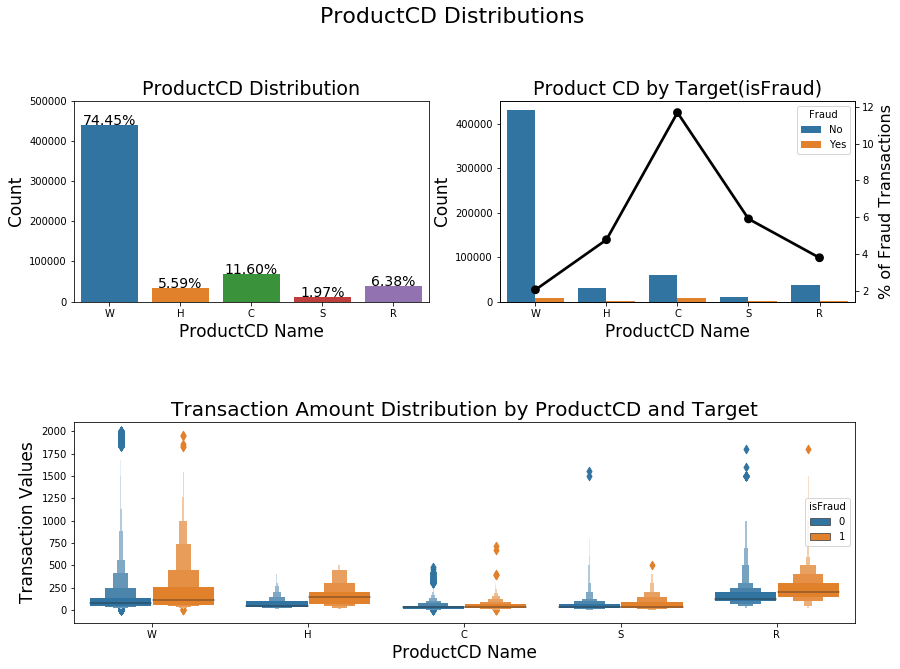

In [0]:
tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Transaction Amount Distribution by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

W, C and R are the most frequent values. <br>
We can note that in **C, S, R** the probability of Fraud observations is **higher**<br>
In the group **W, H, R, the value** of fraud transactions is **higher** 

## 2.4. Card Features
- Based on Competition Description, card features are categoricals.
- Lets understand the distribution of values
- What's the different in transactions and % of Fraud for each values in these features
- Card features has 6 columns, and 4 of them seems to be numericals, so lets see the quantiles and distributions

In [0]:
## Knowning the Card Features
pd.concat([resumetable(df_trans[['card1', 'card2', 'card3','card4', 'card5', 'card6']]),
           resumetable(test_trans[['card1', 'card2', 'card3','card4', 'card5', 'card6']])], axis = 1)

Dataset Shape: (590540, 6)
Dataset Shape: (506691, 6)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,card1,int16,0,0.00,13553,13926,2755,4663,9.97,card1,int16,0,0.00,13244,10409,4272,4476,9.95
1,card2,float16,8933,1.51,500,NaN,404,490,6.32,card2,float16,8654,1.71,497,111,111,574,6.28
2,card3,float16,1565,0.27,114,150,150,150,0.68,card3,float16,3002,0.59,115,150,150,150,0.81
3,card4,object,1577,0.27,4,discover,mastercard,visa,1.09,card4,object,3086,0.61,4,visa,visa,visa,1.05
4,card5,float16,4259,0.72,119,142,102,166,2.66,card5,float16,4547,0.90,102,226,226,226,2.63
5,card6,object,1571,0.27,4,credit,credit,debit,0.82,card6,object,3007,0.59,3,debit,debit,debit,0.79


If we consider card 1 is the principal, obligatory card number for each transaction, logically all the 5 other card variables must be identical for the same card 1. We will check this assumption 

In [0]:
card_EDA = df_trans[['card1', 'card2', 'card3','card4', 'card5', 'card6']].groupby(by = 'card1').nunique()
card_EDA.columns = ['card1_nunique', 'card2_nunique', 'card3_nunique','card4_nunique', 'card5_nunique', 'card6_nunique']
print(card_EDA.apply(lambda x: sum(x>1), axis = 0))
del card_EDA

card1_nunique      0
card2_nunique    248
card3_nunique     21
card4_nunique      0
card5_nunique    239
card6_nunique    103
dtype: int64


This assumption is only true for card4. So for missing value of card4, we will replace by the value of the group aggregated by card1

Card2-Card6 has some missing values. We will need to due with it later. <br>
Card4 and 6 are type of card.

In [0]:
df_trans['card4'].value_counts()

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64

In [0]:
df_trans['card6'].value_counts()

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64

### 2.4.1. Numericals Feature Card Quantiles

In [0]:
print("Card Features Quantiles: ")
pd.DataFrame(df_trans[['card1', 'card2', 'card3', 'card5']].quantile([0.01, .025, .1, .25, .5, .75, .975, .99]))

Card Features Quantiles: 


,card1,card2,card3,card5
0.010,1338.0,100.0,144.0,102.0
0.025,1675.0,111.0,150.0,102.0
0.100,2803.0,111.0,150.0,126.0
0.250,6019.0,214.0,150.0,166.0
0.500,9678.0,361.0,150.0,226.0
0.750,14184.0,512.0,150.0,226.0
0.975,18018.0,583.0,185.0,226.0
0.990,18238.0,583.0,185.0,226.0


In [0]:
print("Card Categorial Frequency Quantiles: ")
card_quantile = pd.DataFrame( index=[0.01, .025, .1, .25, .5, .75,  .85, .9, .975, .99])
for k in ['card1', 'card2', 'card3', 'card5']:
  card_quantile[k] = df_trans[k]. value_counts().quantile([0.01, .025, .1, .25, .5, .75,  .85, .9, .975, .99])
card_quantile

Card Categorial Frequency Quantiles: 


,card1,card2,card3,card5
0.010,1.00,39.000,1.000,1.00
0.025,1.00,50.950,1.000,1.00
0.100,1.00,71.000,1.000,1.00
0.250,1.00,96.000,3.000,3.00
0.500,4.00,176.000,10.000,13.00
0.750,14.00,404.000,64.750,253.00
0.850,28.00,880.350,166.300,746.40
0.900,46.00,1849.500,243.400,2543.20
0.975,258.20,7924.125,1307.825,30506.75
0.990,786.44,18249.890,49225.250,77125.86


In [0]:
df_trans.loc[df_trans.card3.isin(df_trans.card3.value_counts()[df_trans.card3.value_counts() <= 65 ].index), 'card3'] = "Others"
df_trans.loc[df_trans.card5.isin(df_trans.card5.value_counts()[df_trans.card5.value_counts() <= 250 ].index), 'card5'] = "Others"

### 2.4.2. Visualizing Card 1, Card 2 and Card 3 Distributions
- As the Card 1 and 2 are numericals, I will plot the distribution of them
- in Card 3, as we have many values with low frequencies, I decided to set value to "Others" 
- Also, in Card 3 I set the % of Fraud ratio in yaxis2

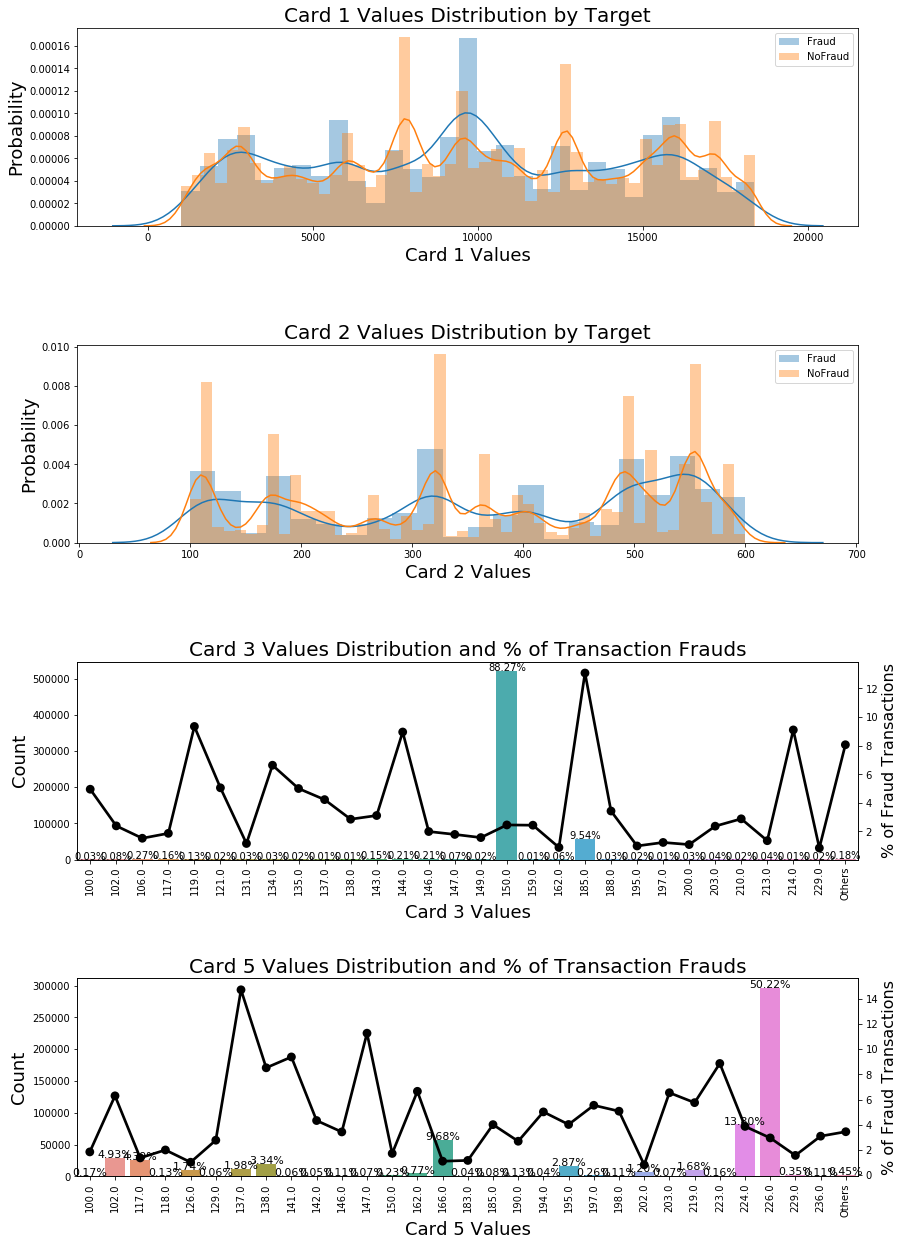

In [0]:
tmp = pd.crosstab(df_trans['card3'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(df_trans['card5'], df_trans['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
g = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
g2 = sns.countplot(x='card3', data=df_trans, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xticklabels(g2.get_xticklabels(),rotation=90)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplot(414)
g3 = sns.countplot(x='card5', data=df_trans, order=list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
g3t.set_ylabel("% of Fraud Transactions", fontsize=16)
g3.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)
g3.set_xlabel("Card 5 Values", fontsize=18)
g3.set_ylabel("Count", fontsize=18)
for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)


plt.show()

In Card3 we can see that 2 groups 150, 185 are the most common values in the column. <br>

In card5 the most frequent values are 226, 224, 166 that represents 73% of data. Also is posible to see high % of frauds in 137, 147, 141 that has few entries for values.

### 2.4.3. Card 4 - Categorical

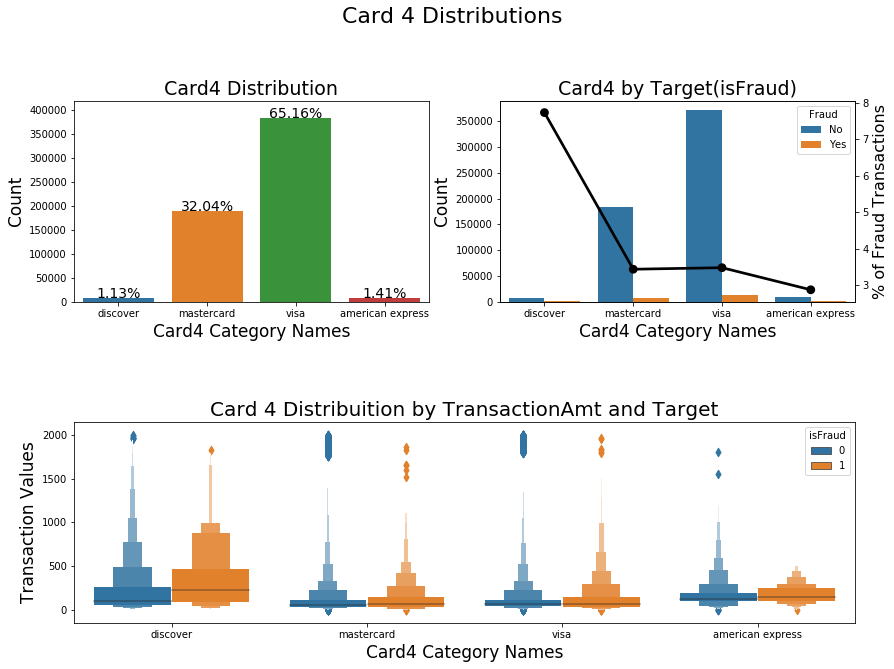

In [0]:
tmp = pd.crosstab(df_trans['card4'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card4', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize=19)
g.set_ylim(0,420000)
g.set_xlabel("Card4 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card4 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Card 4 Distribuition by TransactionAmt and Target", fontsize=20)
g3.set_xlabel("Card4 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

We can see that 97% of our data are in Mastercard(32%) and Visa(65%);  <br>
we have a highest value in discover(~8%) against ~3.5% of Mastercard and Visa and 2.87% in American Express

### 2.4.4. Card 6 - Categorical

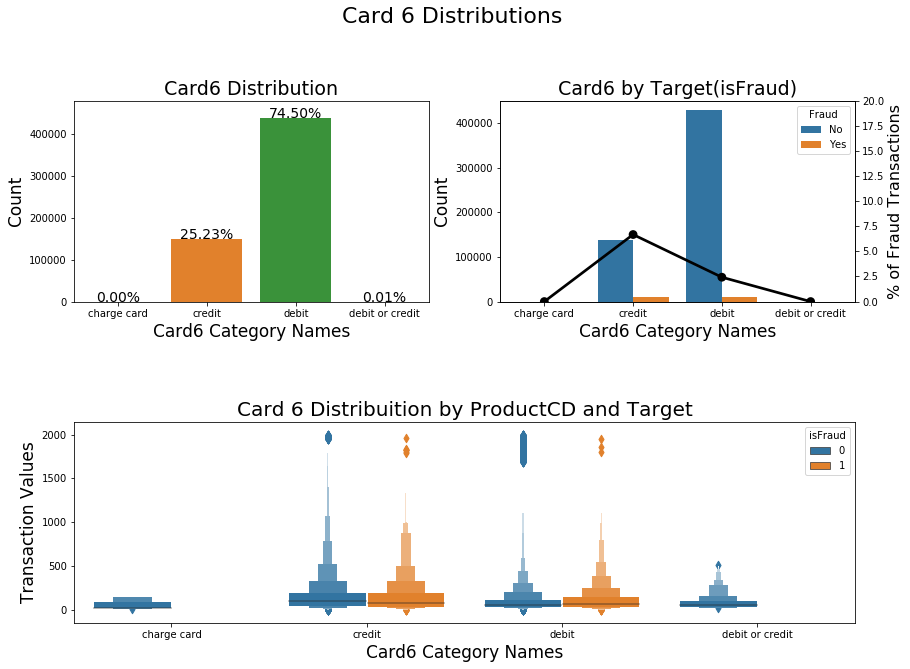

In [0]:
tmp = pd.crosstab(df_trans['card6'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card6', data=df_trans, order=list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card6 Distribution", fontsize=19)
g.set_ylim(0,480000)
g.set_xlabel("Card6 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=df_trans, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
gt.set_ylim(0,20)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card6 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card6 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', order=list(tmp.card6.values),
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card6 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

All data is on Credit and Debit. We can see a high percentual of Frauds in Credit than Debit transactions. <br>
The Distribution of Transaction Amount don't shows clear differences.

## 2.5. Addr1 and Addr2

In [0]:
pd.concat([resumetable(df_trans[['addr1', 'addr2']]),
           resumetable(test_trans[['addr1', 'addr2']])], axis = 1)

Dataset Shape: (590540, 2)
Dataset Shape: (506691, 2)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,addr1,float16,65706,11.13,332,315.0,325.0,330.0,5.06,addr1,float16,65609,12.95,292,170.0,299.0,472.0,5.10
1,addr2,float16,65706,11.13,74,87.0,87.0,87.0,0.08,addr2,float16,65609,12.95,72,87.0,87.0,87.0,0.11


In [0]:
sum(df_trans['addr1'].isna() != df_trans['addr2'].isna())

0

In [0]:
sum(test_trans['addr1'].isna() != test_trans['addr2'].isna())

0

addr1 and addr2 are in pair, if one of each is missing, the another is also missing

In [0]:
print("Train - Addr Features Quantiles: ")
print(df_trans[['addr1', 'addr2']].quantile([0.01, .025, .1, .25, .5, .75, .90,.975, .99]))
print("Test - Addr Features Quantiles: ")
print(test_trans[['addr1', 'addr2']].quantile([0.01, .025, .1, .25, .5, .75, .90,.975, .99]))

Train - Addr Features Quantiles: 
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  441.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0
Test - Addr Features Quantiles: 
       addr1  addr2
0.010  123.0   67.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  441.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0


In [0]:
print("Addr Categorial Frequency Quantiles: ")
addr_quantile = pd.DataFrame( index=[0.01, .025, .1, .25, .5, .75,  .85, .9, .975, .99])
for k in ['addr1', 'addr2']:
  addr_quantile[k] = df_trans[k].value_counts().quantile([0.01, .025, .1, .25, .5, .75,  .85, .9, .975, .99])
addr_quantile

Addr Categorial Frequency Quantiles: 


,addr1,addr2
0.010,1.00,1.00
0.025,1.00,1.00
0.100,1.00,1.00
0.250,1.00,2.00
0.500,3.00,3.50
0.750,21.25,9.50
0.850,945.40,17.00
0.900,3785.30,30.60
0.975,15867.95,1066.05
0.990,35659.27,142781.19


I will set all values in Addr1 that has less than 1000 entries to "Others"<br>
In Addr2 I will set as "Others" all values with less than 20 entries

In [0]:
df_trans.loc[df_trans.addr1.isin(df_trans.addr1.value_counts()[df_trans.addr1.value_counts() <= 1000 ].index), 'addr1'] = "Others"
df_trans.loc[df_trans.addr2.isin(df_trans.addr2.value_counts()[df_trans.addr2.value_counts() <= 20 ].index), 'addr2'] = "Others"

### 2.6.1. Addr1 Distributions

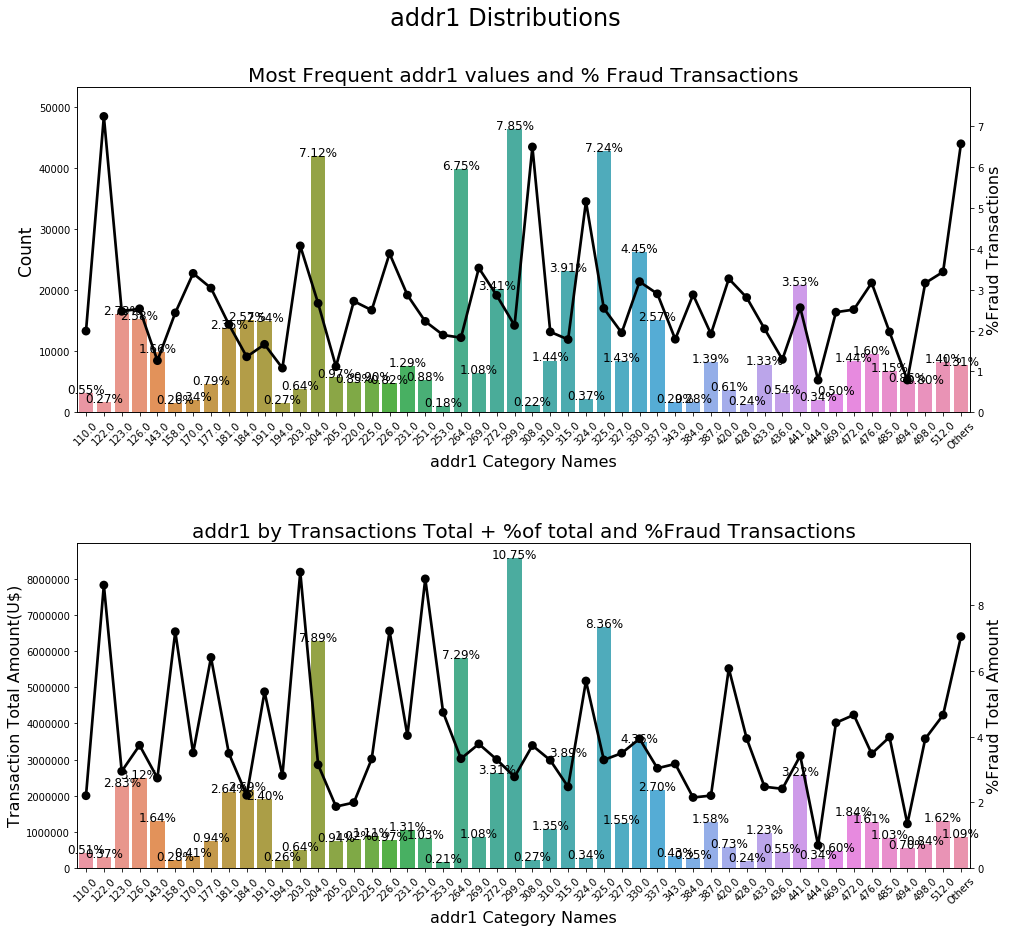

In [0]:
 def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    
ploting_cnt_amt(df_trans, 'addr1')

No clear pattern for Addr1

### 2.6.2. Addr2 Distributions

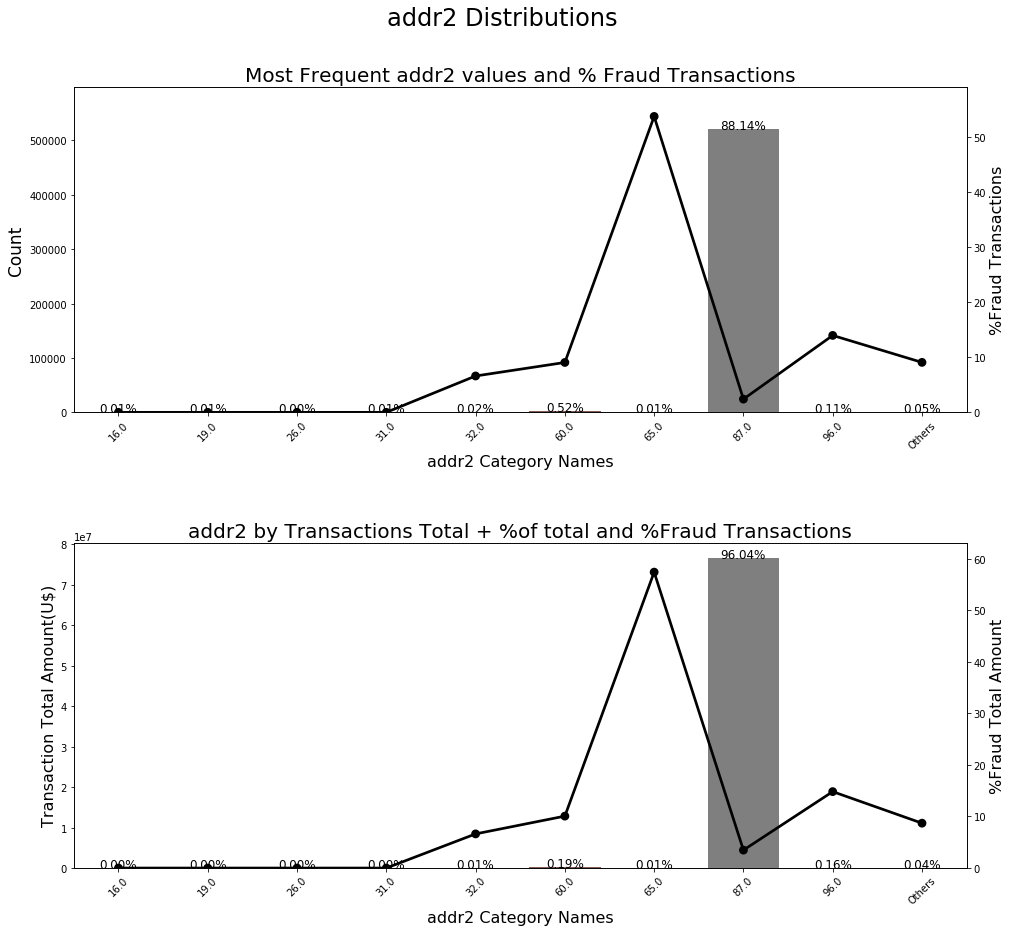

In [0]:
ploting_cnt_amt(df_trans, 'addr2')

Almost all entries in Addr2 are in the same value. <br>
Interestingly in the value 65 , the percent of frauds are almost 60% <br>
Altought the value 87 has 88% of total entries, it has 96% of Total Transaction Amounts

## 2.6. Dist variables

In [0]:
pd.concat([resumetable(df_trans[['dist1', 'dist2']]),
           resumetable(test_trans[['dist1', 'dist2']])], axis = 1)

Dataset Shape: (590540, 2)
Dataset Shape: (506691, 2)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,dist1,float16,352271,59.65,2412,19.0,NaN,287.0,6.33,dist1,float16,291217,57.47,1918,1.0,4.0,2636.0,5.99
1,dist2,float16,552913,93.63,1699,NaN,NaN,NaN,7.41,dist2,float16,470255,92.81,1755,NaN,NaN,NaN,7.89


In [0]:
df_trans['isFraud'].groupby(df_trans['dist1'].fillna('Miss') == 'Miss').mean()

dist1
False    0.019956
True     0.045158
Name: isFraud, dtype: float64

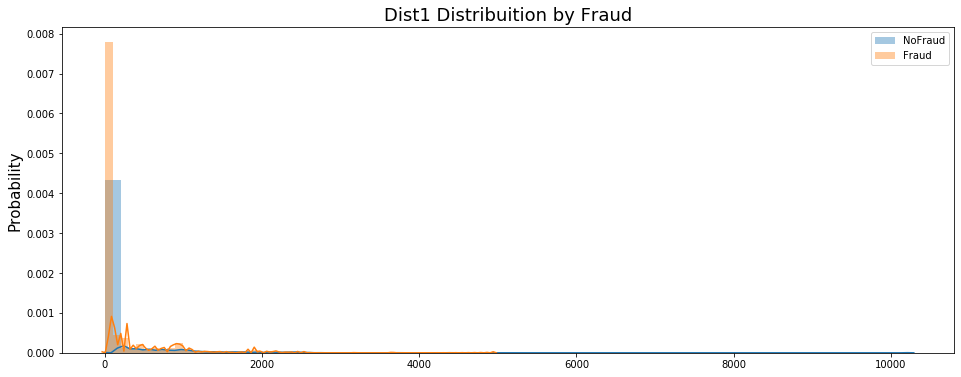

In [0]:
plt.figure(figsize=(16,6))
g = sns.distplot((df_trans[df_trans['isFraud'] == 0]['dist1']), label='NoFraud')
g = sns.distplot((df_trans[df_trans['isFraud'] == 1]['dist1']), label='Fraud')
g= plt.title("Dist1 Distribuition by Fraud", fontsize=18)
g = plt.xlabel("")
g = plt.ylabel("Probability", fontsize=15)
g = plt.legend()

No clearly pattern for the distribution of dist1 by Fraud. However, the percentage of Fraud is 2 times higher while dist1 is missing. Transforming dist1 to categorical variable (1 if missing, 0 if not)

## 2.7. emaildomain Distributions


In [0]:
resumetable(df_trans[['P_emaildomain','R_emaildomain']])

Dataset Shape: (590540, 2)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,P_emaildomain,object,94456,15.99,59,NaN,gmail.com,outlook.com,2.68
1,R_emaildomain,object,453249,76.75,60,NaN,NaN,NaN,2.76


In [0]:
df_trans[['P_emaildomain','R_emaildomain']].apply(lambda x: x.value_counts()).sort_values('P_emaildomain', ascending=False)

,P_emaildomain,R_emaildomain
gmail.com,228355.0,57147
yahoo.com,100934.0,11842
hotmail.com,45250.0,27509
anonymous.com,36998.0,20529
aol.com,28289.0,3701
comcast.net,7888.0,1812
icloud.com,6267.0,1398
outlook.com,5096.0,2507
msn.com,4092.0,852
att.net,4033.0,430


In [0]:
print("Emaildomain Categorial Frequency Quantiles: ")
email_quantile = pd.DataFrame( index=[0.01, .025, .1, .25, .5, .75,  .85, .9, .975, .99])
for k in ['P_emaildomain', 'R_emaildomain']:
  email_quantile[k] = df_trans[k].value_counts().quantile([0.01, .025, .1, .25, .5, .75,  .85, .9, .975, .99])
email_quantile

Emaildomain Categorial Frequency Quantiles: 


,P_emaildomain,R_emaildomain
0.010,33.74,8.590
0.025,38.60,10.425
0.100,72.80,25.000
0.250,173.50,40.500
0.500,305.00,113.500
0.750,1726.00,482.250
0.850,4050.70,933.900
0.900,6591.20,1881.500
0.975,75876.20,24193.500
0.990,154450.82,39660.580


### 2.7.1. P-Email Domain

In [0]:
df_trans.loc[df_trans['P_emaildomain'].isin(['yahoo.co.uk','yahoo.co.jp', 
                                             'yahoo.de', 'yahoo.fr','yahoo.es']),
             'P_emaildomain'] = 'yahoo.com'
df_trans.loc[df_trans['P_emaildomain'].isin(['hotmail.es','hotmail.co.uk', 'hotmail.de','hotmail.fr']), 
             'P_emaildomain'] = 'hotmail.com'
df_trans.loc[df_trans['P_emaildomain'].isin(['outlook.es']), 
             'P_emaildomain'] = 'outlook.com'
df_trans.loc[df_trans['P_emaildomain'].isin(['outlook.es']), 
             'P_emaildomain'] = 'outlook.com'
df_trans.loc[df_trans['P_emaildomain'].isin(['live.fr']), 
             'P_emaildomain'] = 'live.com'
df_trans.loc[df_trans.P_emaildomain.isin(df_trans.P_emaildomain\
                                         .value_counts()[df_trans.P_emaildomain.value_counts() <= 300 ]\
                                         .index), 'P_emaildomain'] = "Others"
df_trans.P_emaildomain.fillna("NoInf", inplace=True)

df_trans['P_email_MX'] = 1*(df_trans['P_emaildomain'].apply(lambda x: 'mx' in x))

#### Ploting P-Email Domain

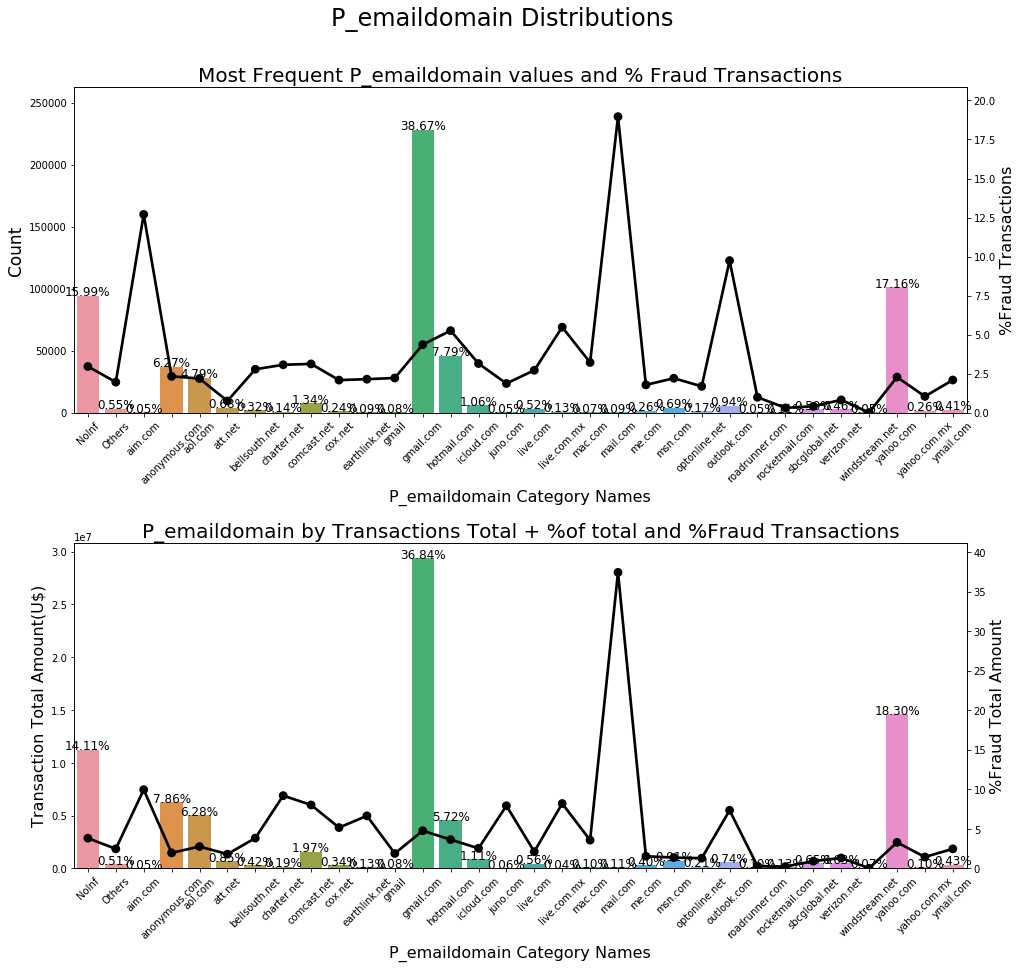

In [0]:
ploting_cnt_amt(df_trans, 'P_emaildomain')

gmail is the most common class. Interesting thing is that the class "mail.com" has high probability of Fraud.

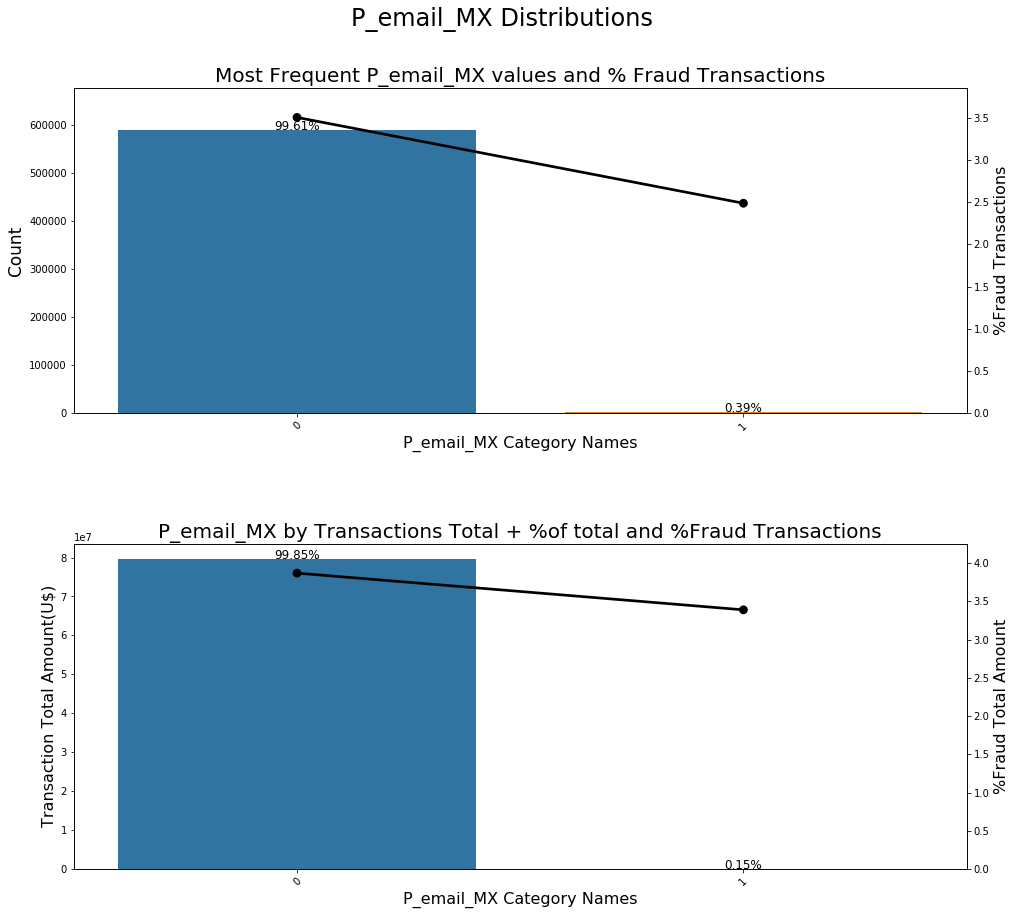

In [0]:
ploting_cnt_amt(df_trans, 'P_email_MX')

### 2.7.2. R-Email Domain plot distribution


In [0]:
df_trans.loc[df_trans['R_emaildomain'].isin(['yahoo.co.uk','yahoo.co.jp', 
                                             'yahoo.de', 'yahoo.fr','yahoo.es']),
             'R_emaildomain'] = 'yahoo.com'
df_trans.loc[df_trans['R_emaildomain'].isin(['hotmail.es','hotmail.co.uk', 'hotmail.de','hotmail.fr']), 
             'R_emaildomain'] = 'hotmail.com'
df_trans.loc[df_trans['R_emaildomain'].isin(['outlook.es']), 
             'R_emaildomain'] = 'outlook.com'
df_trans.loc[df_trans['R_emaildomain'].isin(['outlook.es']), 
             'R_emaildomain'] = 'outlook.com'
df_trans.loc[df_trans['R_emaildomain'].isin(['live.fr']), 
             'R_emaildomain'] = 'live.com'
df_trans.loc[df_trans.R_emaildomain.isin(df_trans.R_emaildomain\
                                         .value_counts()[df_trans.R_emaildomain.value_counts() <= 110 ]\
                                         .index), 'R_emaildomain'] = "Others"
df_trans.R_emaildomain.fillna("NoInf", inplace=True)

df_trans['R_email_MX'] = 1*(df_trans['R_emaildomain'].apply(lambda x: 'mx' in x))

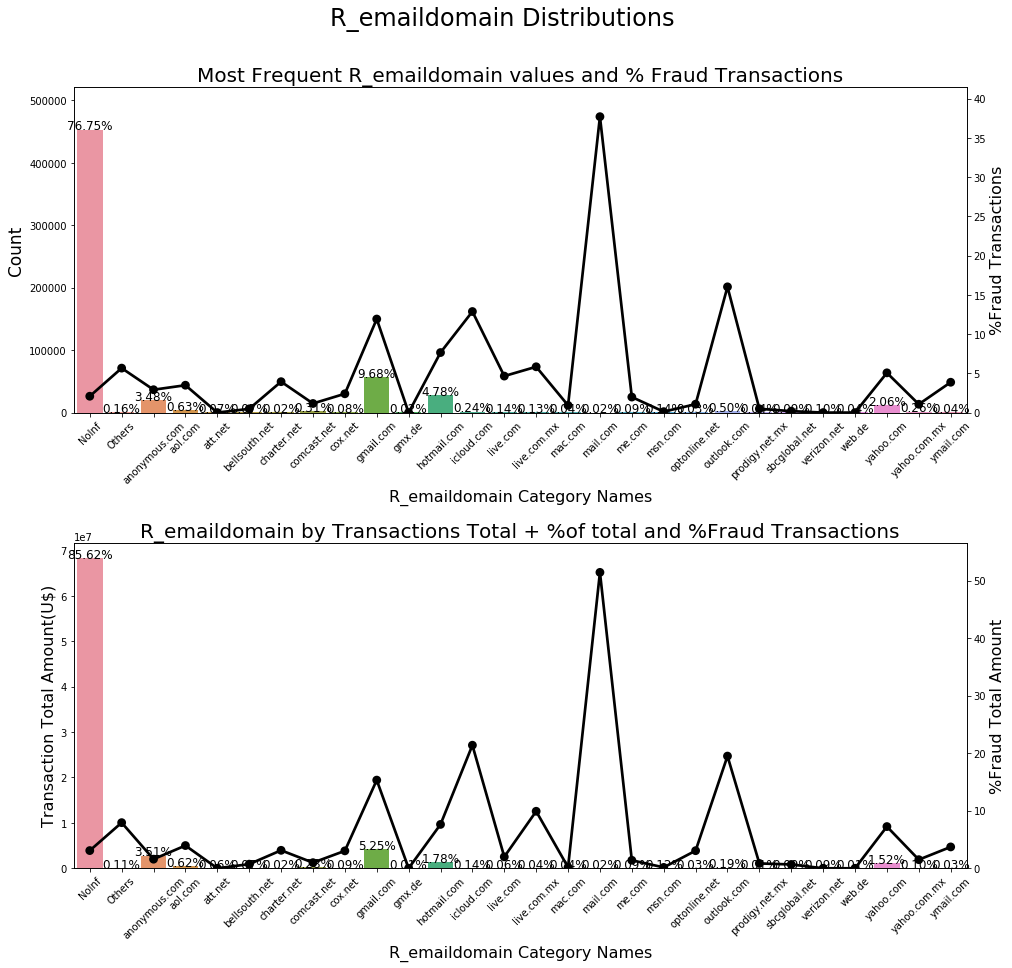

In [0]:
ploting_cnt_amt(df_trans, 'R_emaildomain')

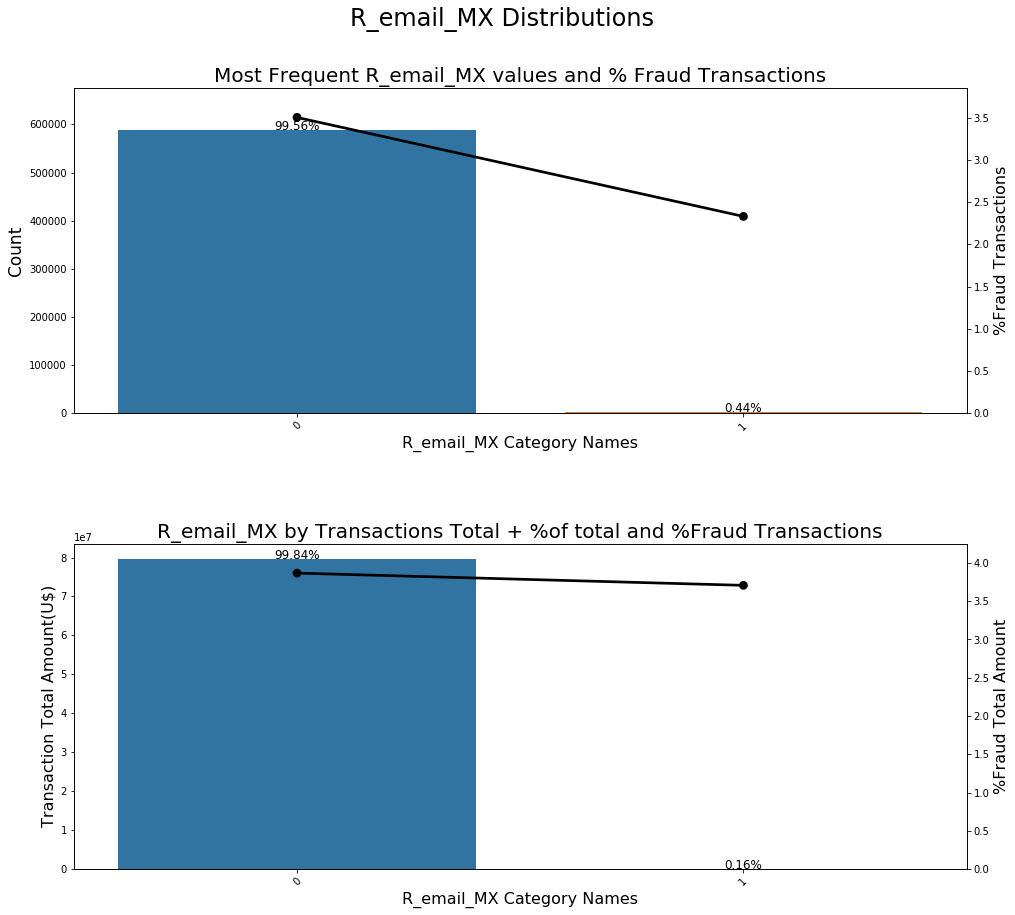

In [0]:
ploting_cnt_amt(df_trans, 'R_email_MX')

We can see a very similar distribution in both email domain features. <br>
It's interesting that we have high values in google and icloud frauds

In [0]:
df_trans.drop(['R_email_MX', 'P_email_MX'], axis = 1, inplace = True)

## 2.8. C1-C14 features

- Let's understand what this features are.
- What's the distributions? 

In [0]:
resumetable(df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']])

Dataset Shape: (590540, 14)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,C1,float16,0,0.0,1495,1.0,1.0,1.0,2.72
1,C2,float16,0,0.0,1167,1.0,1.0,1.0,2.75
2,C3,float16,0,0.0,27,0.0,0.0,0.0,0.04
3,C4,float16,0,0.0,1223,0.0,0.0,0.0,1.12
4,C5,float16,0,0.0,319,0.0,0.0,0.0,2.06
5,C6,float16,0,0.0,1291,1.0,1.0,1.0,2.52
6,C7,float16,0,0.0,1069,0.0,0.0,0.0,0.71
7,C8,float16,0,0.0,1130,0.0,0.0,0.0,1.25
8,C9,float16,0,0.0,205,1.0,0.0,1.0,2.62
9,C10,float16,0,0.0,1122,0.0,0.0,0.0,1.23


In [0]:
for k in ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']:
    print(sum(df_trans[k] % 1 !=0))

0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [0]:
print("C Categorial Frequency Quantiles: ")
c_quantile = pd.DataFrame( index=[0.01, .025, .1, .25, .5, .75,  .85, .9, .975, .99])
for k in ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']:
  c_quantile[k] = df_trans[k].value_counts().quantile([0.01, .025, .1, .25, .5, .75,  .85, .9, .975, .99])
c_quantile

C Categorial Frequency Quantiles: 


,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0.010,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.000,1.000
0.025,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00,2.00,1.00,1.00,1.00,1.000,1.000
0.100,1.00,1.00,1.00,1.00,4.00,1.0,1.0,1.00,5.00,1.00,1.00,1.00,1.000,1.000
0.250,1.00,1.00,1.00,1.00,16.00,1.0,1.0,1.00,21.00,1.00,1.00,1.00,2.000,1.000
0.500,2.00,3.00,2.00,1.00,59.00,2.0,1.0,1.00,97.00,1.50,2.00,1.00,8.000,2.000
0.750,4.00,8.50,5.00,3.00,163.50,4.0,2.0,3.00,278.00,3.00,4.00,2.00,38.000,5.000
0.850,20.00,53.10,12.10,4.00,221.30,11.0,3.0,6.00,375.40,6.00,11.00,4.00,82.550,31.950
0.900,71.60,131.40,106.80,5.00,241.80,54.0,4.0,9.00,410.80,9.00,67.40,7.00,111.000,92.300
0.975,271.65,312.70,207227.90,33.35,1466.15,349.0,35.6,50.55,8359.20,69.00,344.45,34.75,1380.275,336.975
0.990,736.74,1699.28,435757.76,155.78,12044.02,784.4,135.6,326.52,76016.04,374.36,663.78,131.15,6528.910,1707.500


In [0]:
df_trans['C1'].value_counts().head(25)

1.0      316791
2.0      105071
3.0       51315
4.0       28845
5.0       17922
6.0       10567
7.0        7263
8.0        5072
9.0        3612
10.0       2904
11.0       2167
12.0       1965
13.0       1460
14.0       1116
15.0        858
16.0        729
17.0        715
18.0        578
19.0        494
0.0         494
20.0        437
21.0        375
22.0        369
24.0        323
117.0       322
Name: C1, dtype: int64

### 2.8.1. C1 Distribution Plot

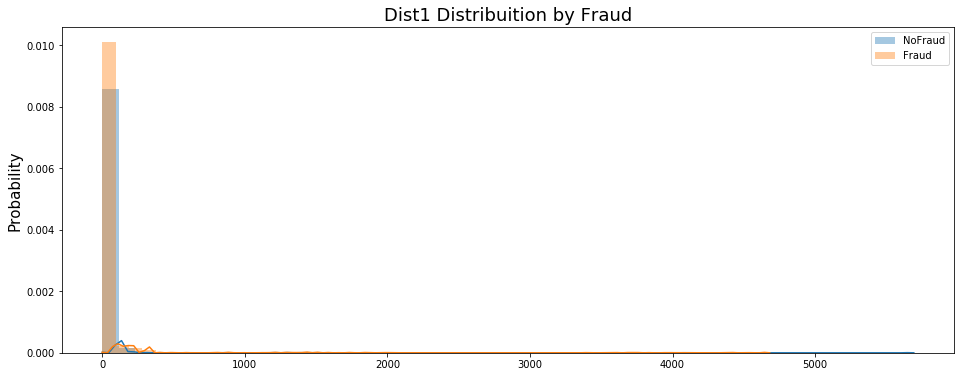

In [0]:
plt.figure(figsize=(16,6))
g = sns.distplot((df_trans[df_trans['isFraud'] == 0]['C2']), label='NoFraud')
g = sns.distplot((df_trans[df_trans['isFraud'] == 1]['C1']), label='Fraud')
g= plt.title("Dist1 Distribuition by Fraud", fontsize=18)
g = plt.xlabel("")
g = plt.ylabel("Probability", fontsize=15)
g = plt.legend()

Top 3 values are 1, 2 and 3 and is the same on Total Amounts. We see the same pattern on fraud ratios

## 2.9. Exploring M1-M9 Features 

In [0]:
resumetable(df_trans[['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']])

Dataset Shape: (590540, 9)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,M1,object,271100,45.91,2,T,NaN,T,0.00
1,M2,object,271100,45.91,2,T,NaN,T,0.49
2,M3,object,271100,45.91,2,T,NaN,T,0.75
3,M4,object,281444,47.66,3,M2,M0,M0,1.31
4,M5,object,350482,59.35,2,F,T,F,0.99
5,M6,object,169360,28.68,2,T,T,F,1.00
6,M7,object,346265,58.64,2,NaN,NaN,F,0.57
7,M8,object,346252,58.63,2,NaN,NaN,F,0.95
8,M9,object,346252,58.63,2,NaN,NaN,F,0.63


In [0]:
sum(df_trans['M1'].isna() != df_trans['M2'].isna())

0

In [0]:
sum(df_trans['M1'].isna() != df_trans['M3'].isna())

0

In [0]:
sum(df_trans['M8'].isna() != df_trans['M9'].isna())

0

- M1, M2, M3 are triplet, if one of each is missing, the other are also missing.
- M8, M9 are in pair


In [0]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    df_trans[col] = df_trans[col].fillna("Miss")
    
def ploting_dist_ratio(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{col} Distributions ', fontsize=22)

    plt.subplot(121)
    g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    g.set_title(f"{col} Distribution\nCound and %Fraud by each category", fontsize=18)
    g.set_ylim(0,400000)
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,20)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    for p in gt.patches:
        height = p.get_height()
        gt.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (df_trans.groupby(['isFraud',col])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    g1 = sns.boxplot(x=col, y='TransactionAmt', hue='isFraud', 
                     data=df[df['TransactionAmt'] <= lim], order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,5)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g1.set_title(f"{col} by Transactions dist", fontsize=18)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Amount(U$)", fontsize=16)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    plt.show()


### M distributions:  Count, %Fraud and Transaction Amount distribution

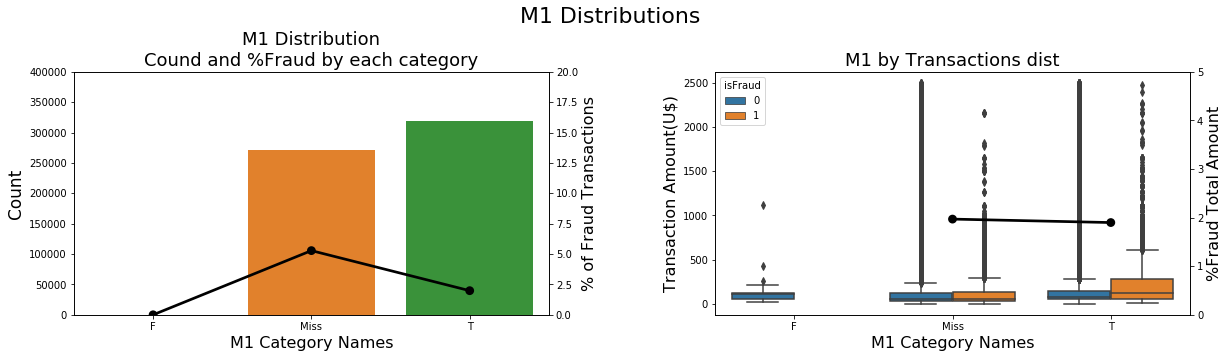

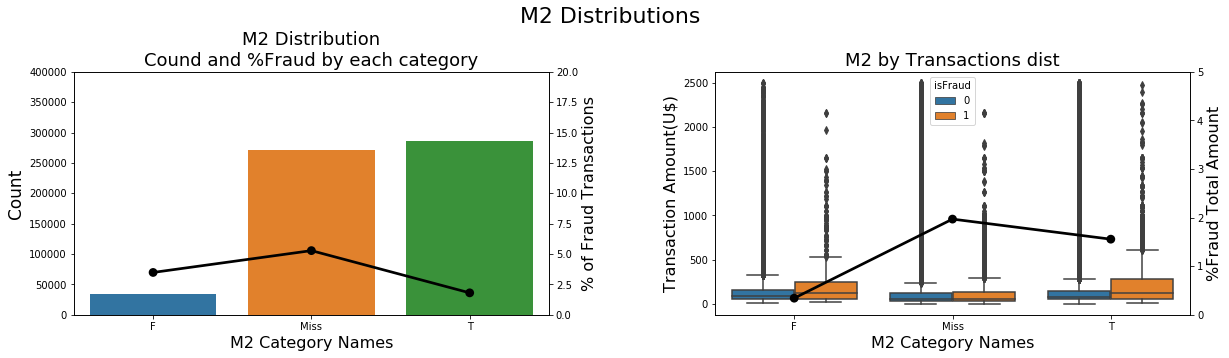

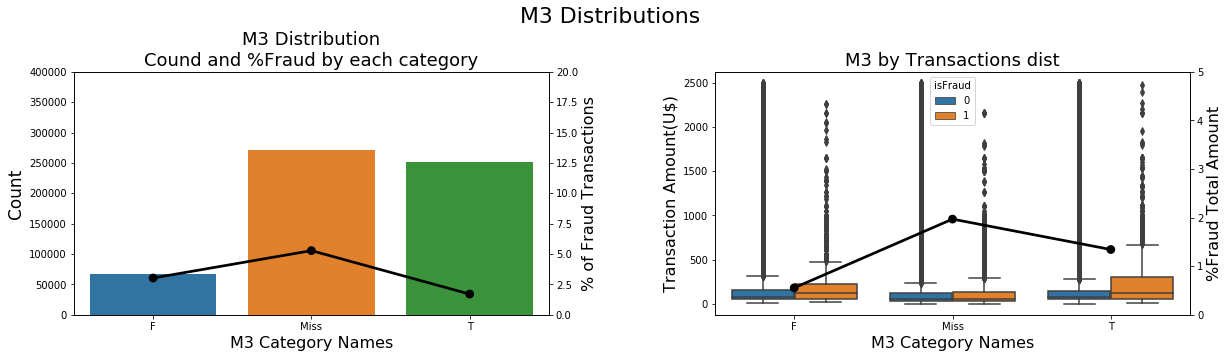

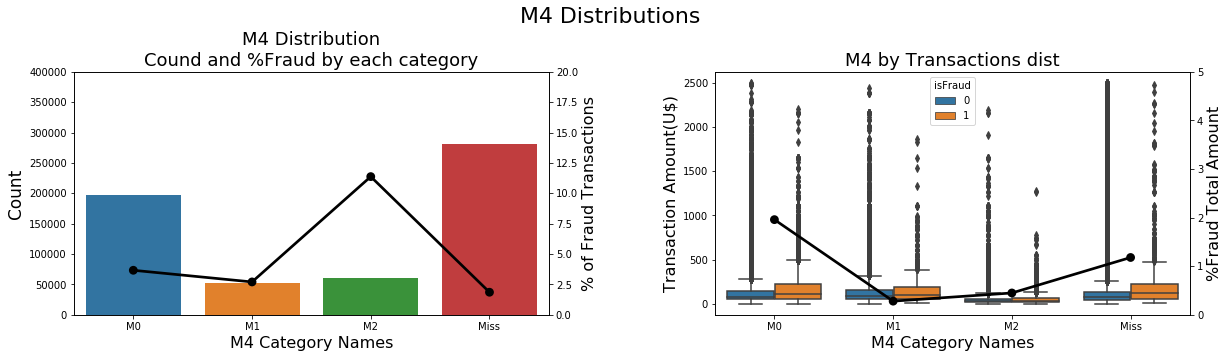

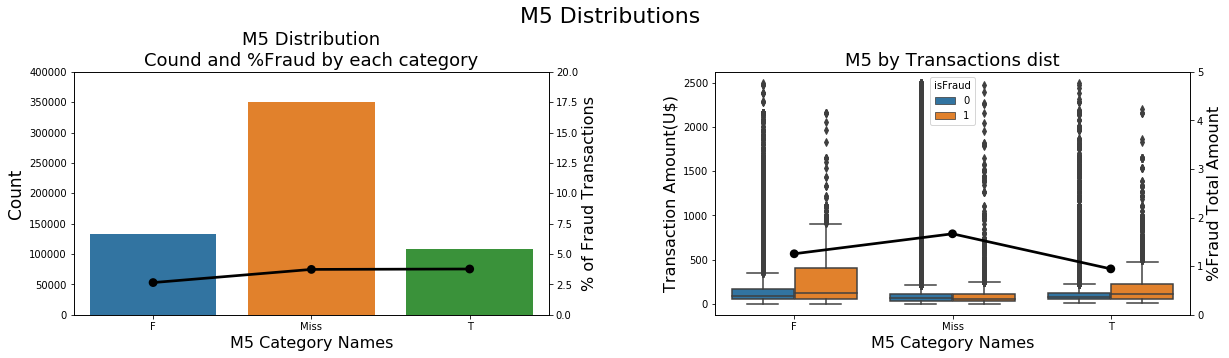

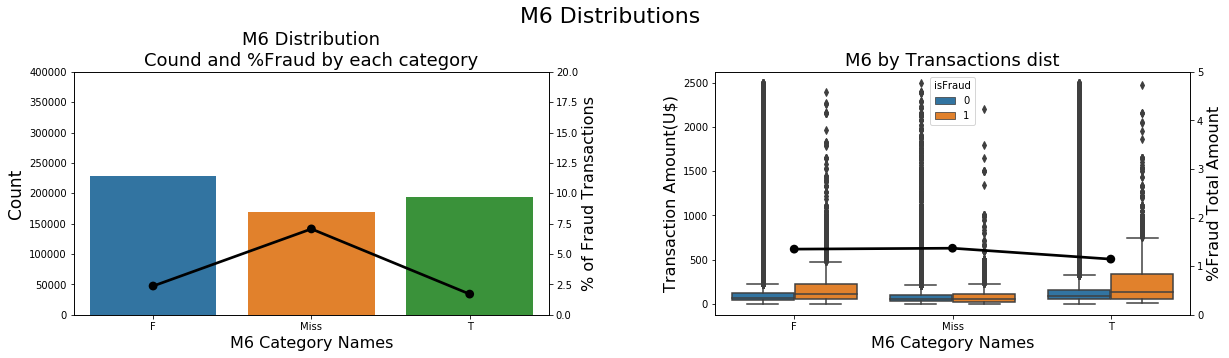

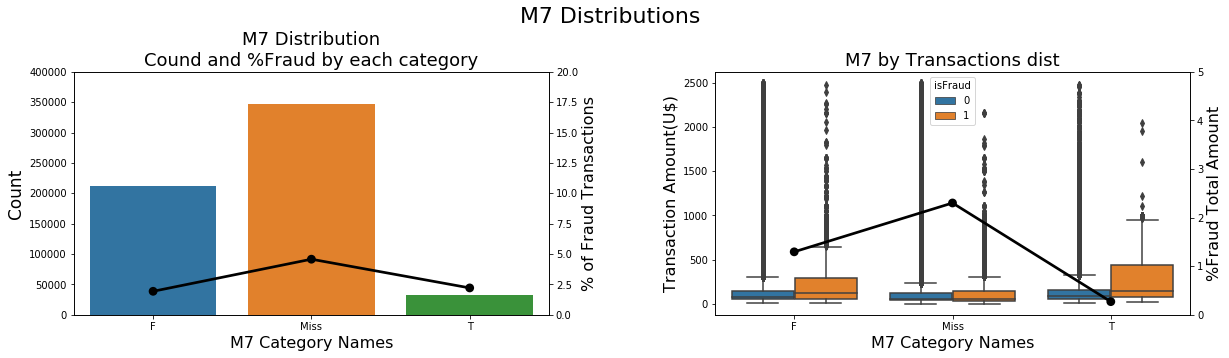

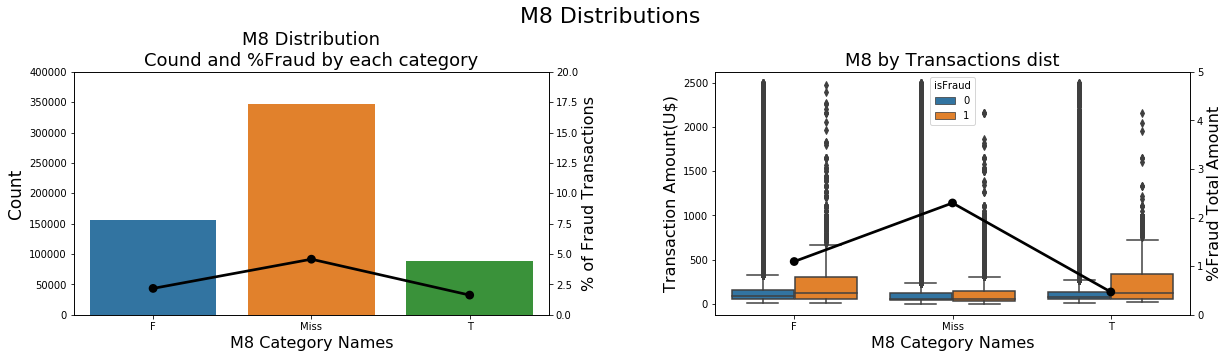

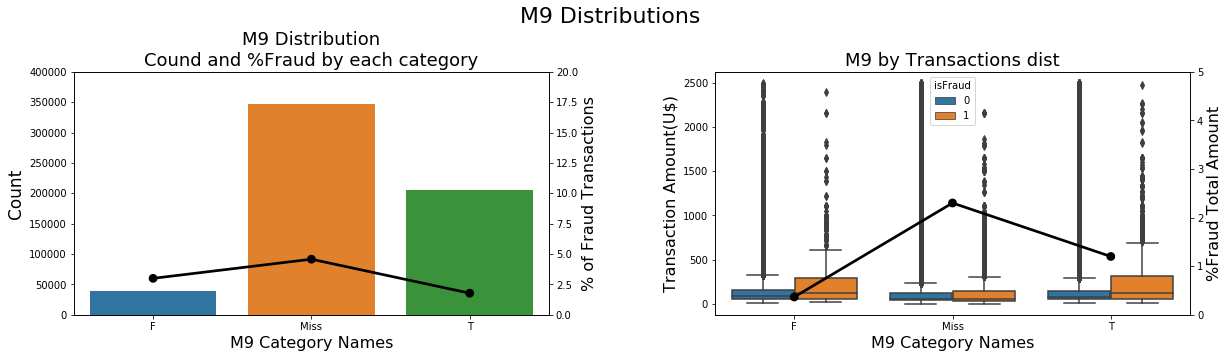

In [0]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    ploting_dist_ratio(df_trans, col, lim=2500)

Very cool!!! This graphs give us many interesting intuition about the M features.<br>
Only in M4 the Missing values haven't the highest % of Fraud.


## 2.10. TimeDelta Feature
- Let's see if the frauds have some specific hour that has highest % of frauds 


In discussions tab I read an excellent solution to Timedelta column, I will set the link below; <br>
We will use the first date as 2017-12-01 and use the delta time to compute datetime features


In [0]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#latest-579480
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df_trans["Date"] = df_trans['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

df_trans['_Weekdays'] = df_trans['Date'].dt.dayofweek
df_trans['_Hours'] = df_trans['Date'].dt.hour
df_trans['_Days'] = df_trans['Date'].dt.day

## 2.10.1 Top Days with highest Total Transaction Amount

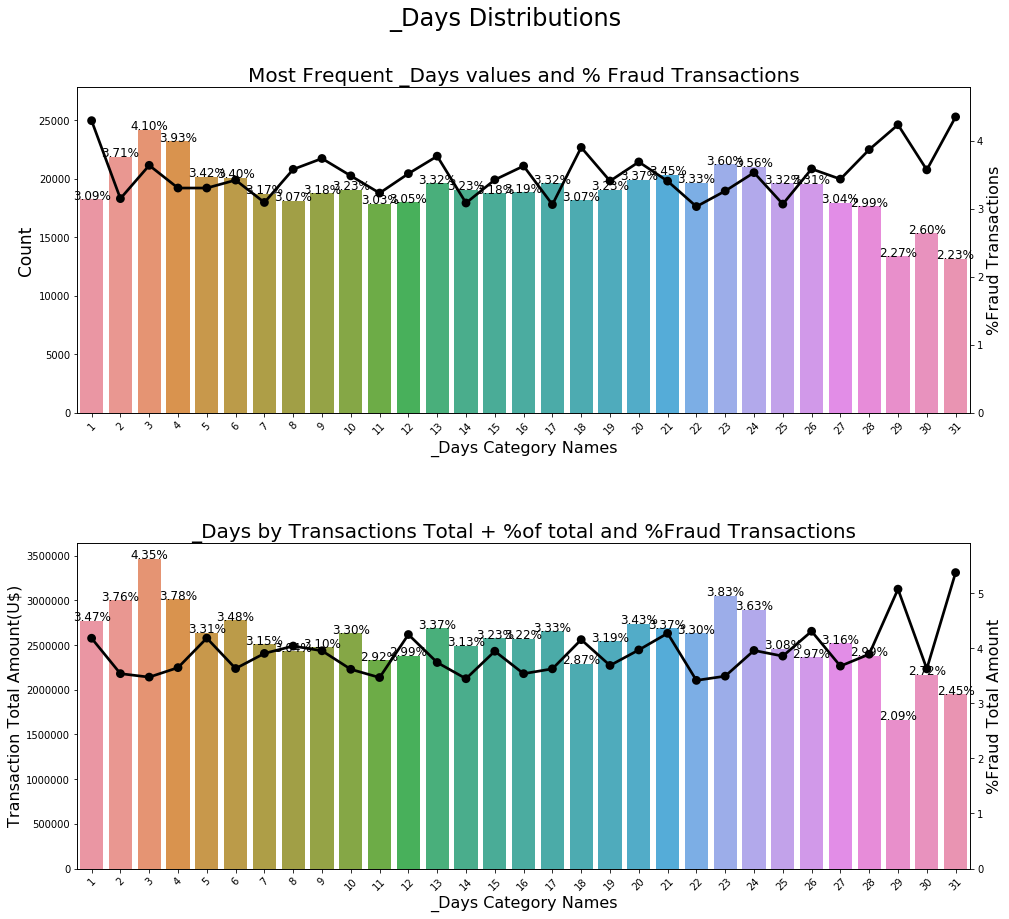

In [0]:
ploting_cnt_amt(df_trans, '_Days')

## 2.10.2 Ploting WeekDays Distributions

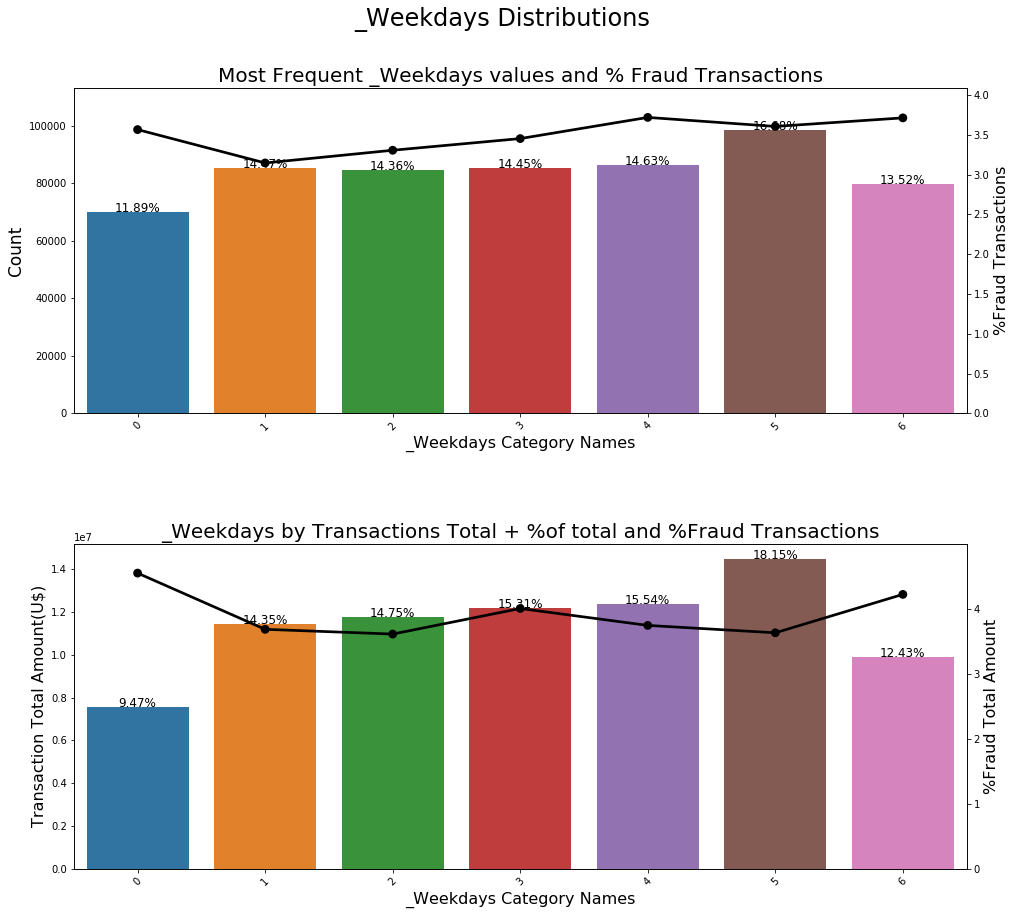

In [0]:
ploting_cnt_amt(df_trans, '_Weekdays')

We don't have the reference of date but we can see that two days has lower transactions, that we can infer it is weekend days

## 2.10.3 Ploting Hours Distributions

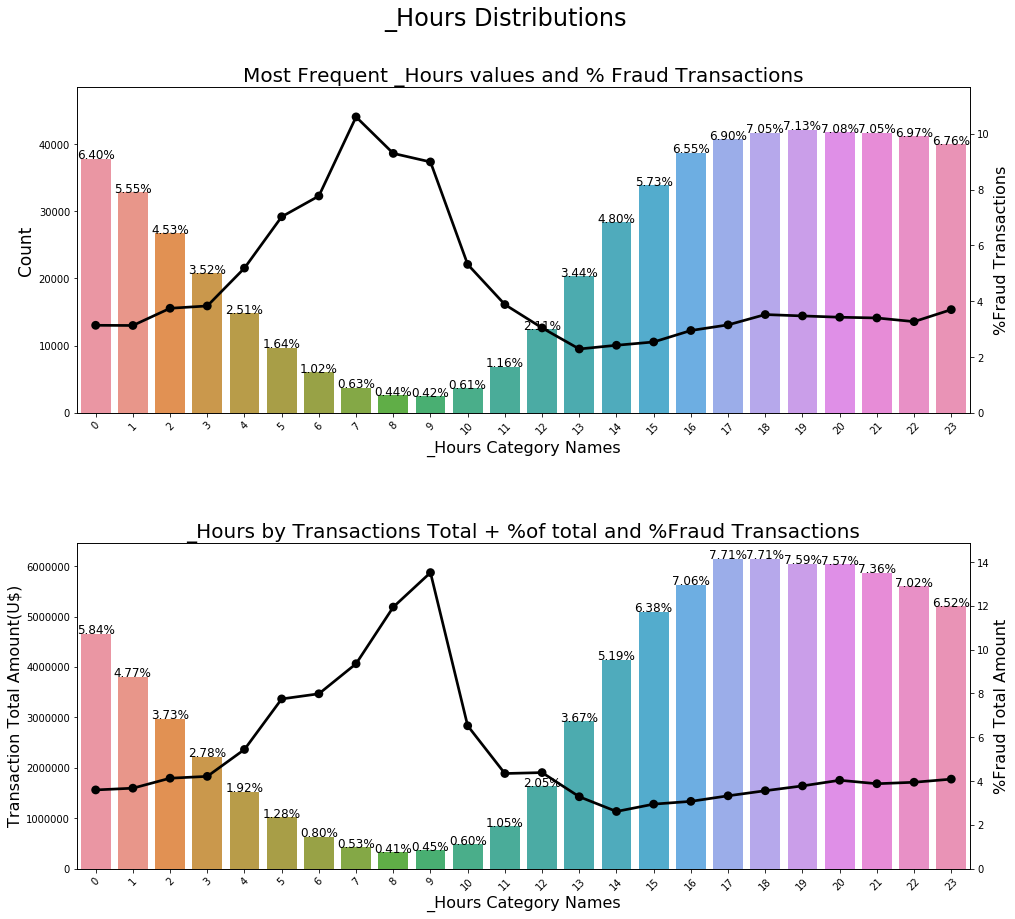

In [0]:
ploting_cnt_amt(df_trans, '_Hours')

## 2.11. Features [id_12 to id_38]
- categorical features in training identity dataset

In [0]:
resumetable(df_id)

Dataset Shape: (144233, 41)


,Name,dtypes,Missing,Missing %,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,0.00,144233,2987004,2987008,2987010,17.14
1,id_01,float16,0,0.00,77,0,-5,-5,2.27
2,id_02,float32,3361,2.33,115655,70787,98945,191631,16.72
3,id_03,float16,77909,54.02,24,NaN,NaN,0,0.32
4,id_04,float16,77909,54.02,15,NaN,NaN,0,0.10
5,id_05,float16,7368,5.11,93,NaN,0,0,2.40
6,id_06,float16,7368,5.11,101,NaN,-5,0,2.63
7,id_07,float16,139078,96.43,84,NaN,NaN,NaN,5.39
8,id_08,float16,139078,96.43,94,NaN,NaN,NaN,5.72
9,id_09,float16,69307,48.05,46,NaN,NaN,0,0.51


In [0]:
df_train = df_trans.merge(df_id, how='left', left_index=True, right_index=True)

In [0]:
def cat_feat_ploting(df, col):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(14,10))
    plt.suptitle(f'{col} Distributions', fontsize=22)

    plt.subplot(221)
    g = sns.countplot(x=col, data=df, order=tmp[col].values)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"{col} Distribution", fontsize=19)
    g.set_xlabel(f"{col} Name", fontsize=17)
    g.set_ylabel("Count", fontsize=17)
    # g.set_ylim(0,500000)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 

    plt.subplot(222)
    g1 = sns.countplot(x=col, hue='isFraud', data=df, order=tmp[col].values)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
    gt = g1.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=tmp[col].values, legend=False)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)

    g1.set_title(f"{col} by Target(isFraud)", fontsize=19)
    g1.set_xlabel(f"{col} Name", fontsize=17)
    g1.set_ylabel("Count", fontsize=17)

    plt.subplot(212)
    g3 = sns.boxenplot(x=col, y='TransactionAmt', hue='isFraud', 
                       data=df[df['TransactionAmt'] <= 2000], order=tmp[col].values )
    g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
    g3.set_xlabel("ProductCD Name", fontsize=17)
    g3.set_ylabel("Transaction Values", fontsize=17)

    plt.subplots_adjust(hspace = 0.4, top = 0.85)

    plt.show()

## Ploting columns with few unique values

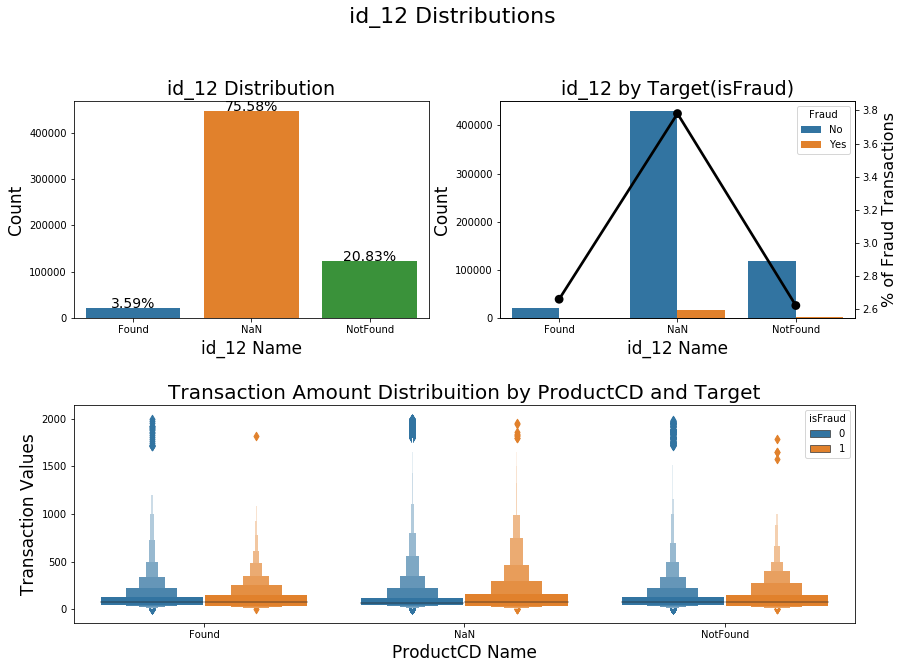

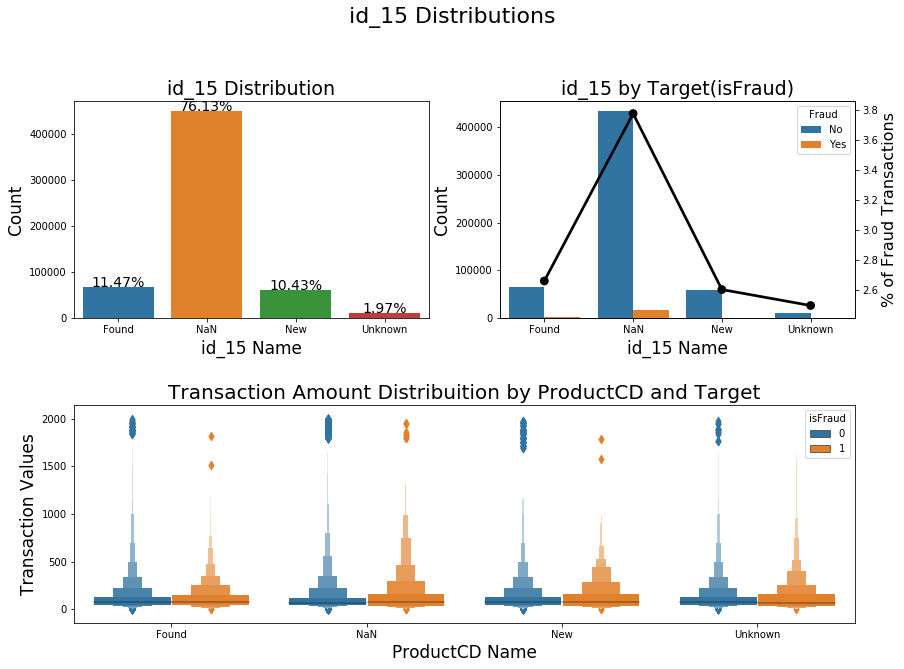

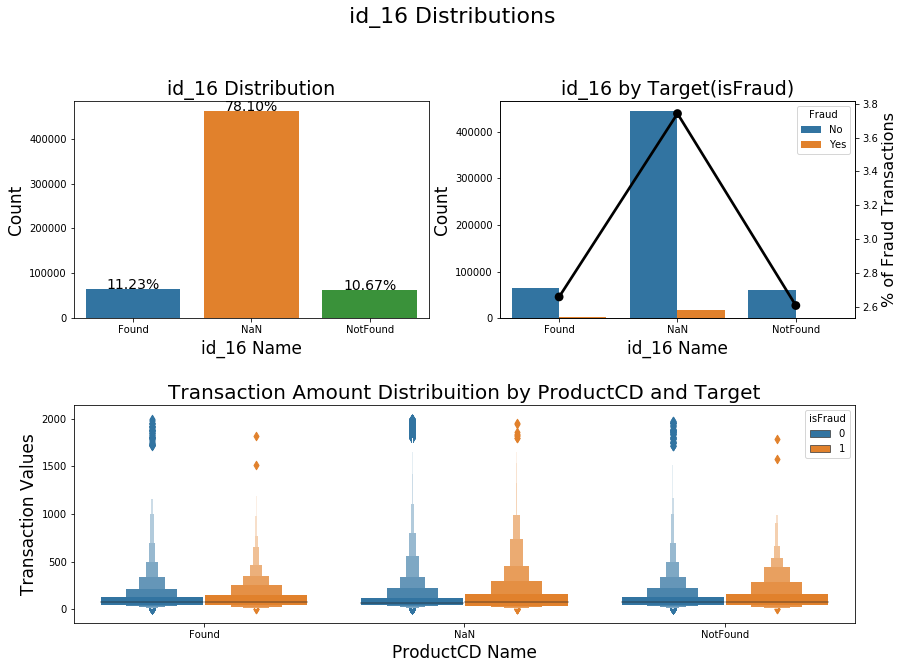

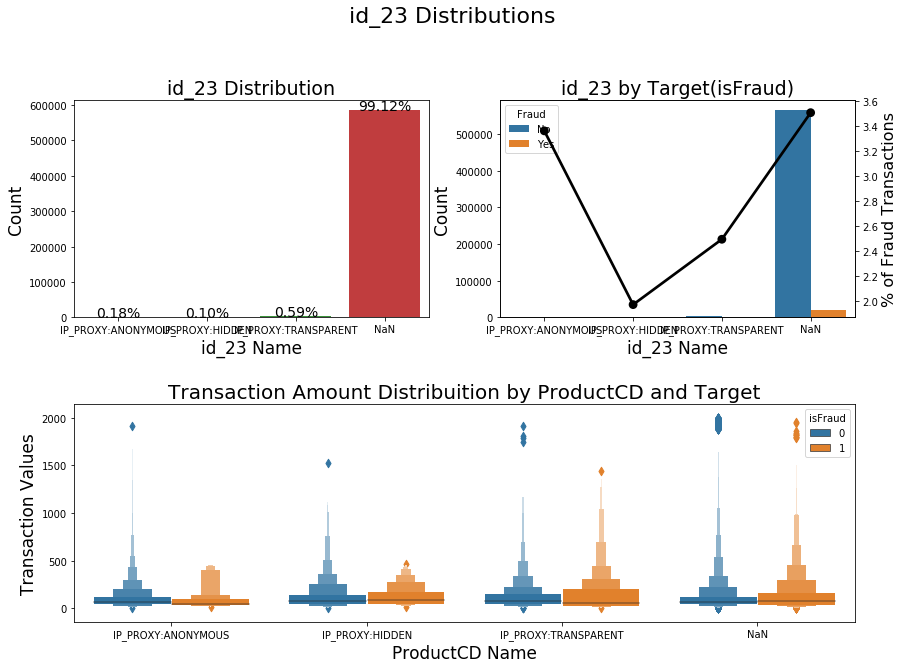

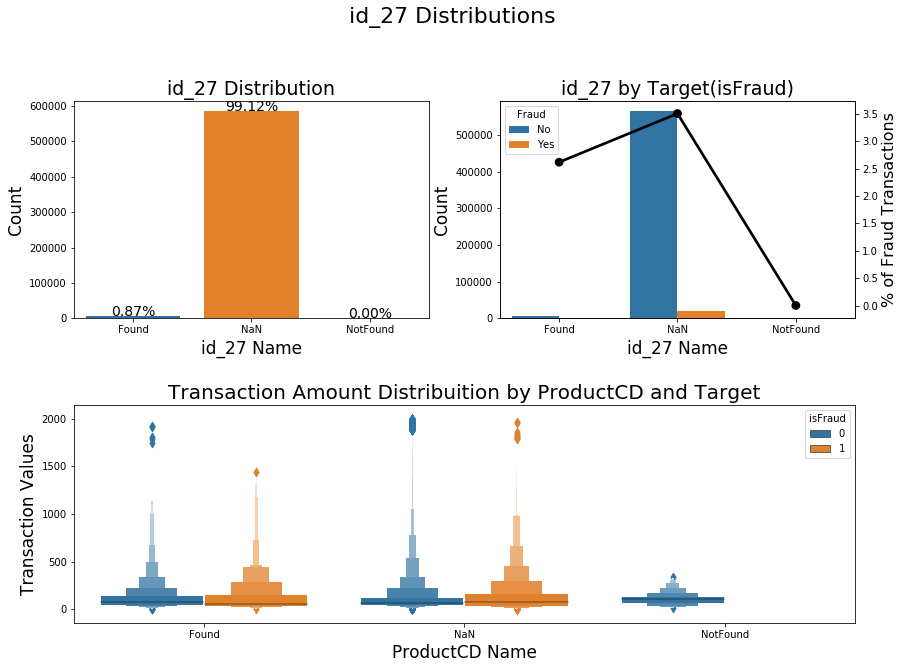

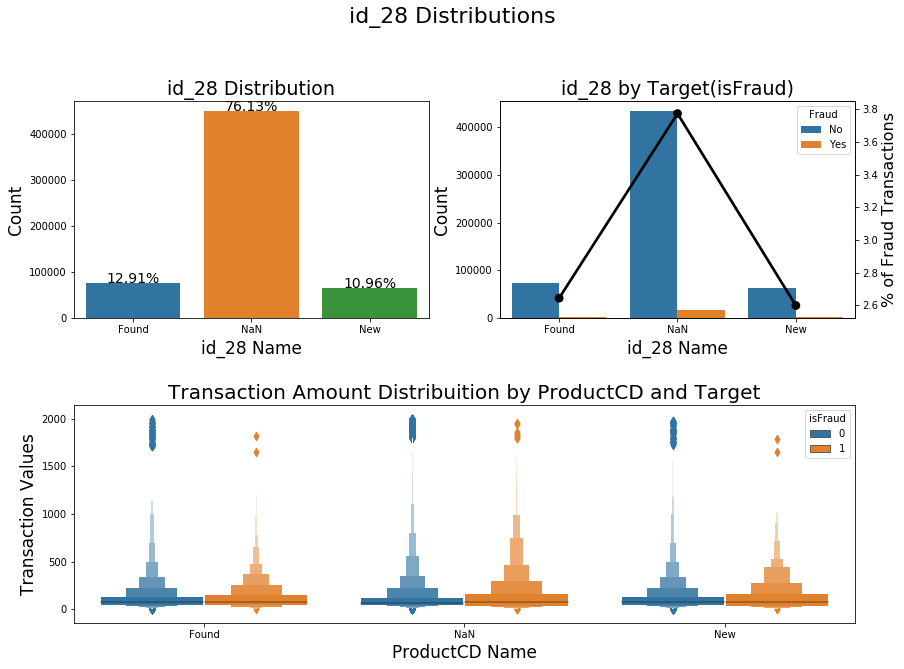

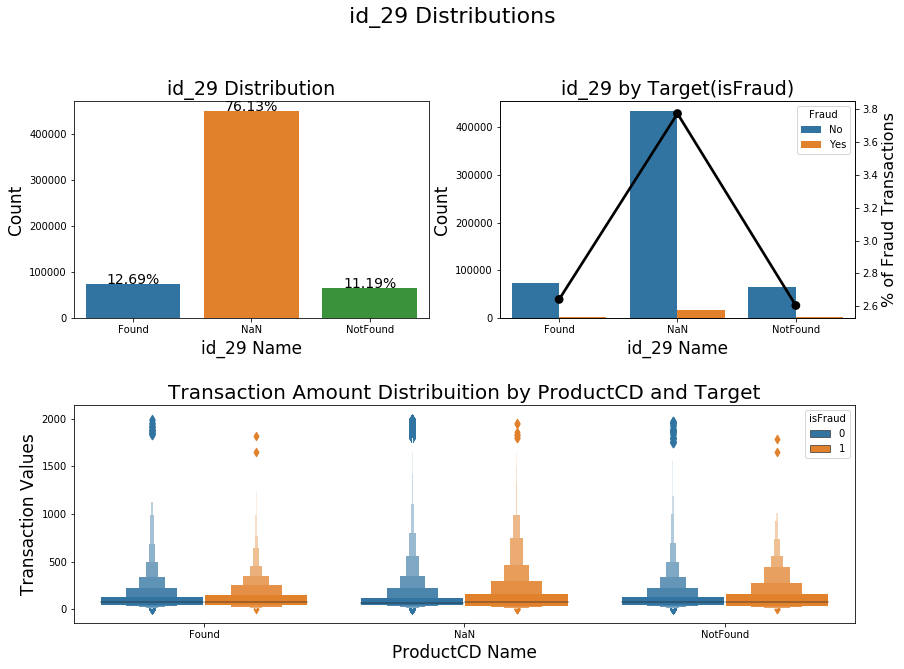

In [0]:
for col in ['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29']:
    df_train[col] = df_train[col].fillna('NaN')
    cat_feat_ploting(df_train, col)

## Id 30

In [0]:
df_train.loc[df_train['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
df_train.loc[df_train['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
df_train.loc[df_train['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
df_train.loc[df_train['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
df_train['id_30'].fillna("NAN", inplace=True)

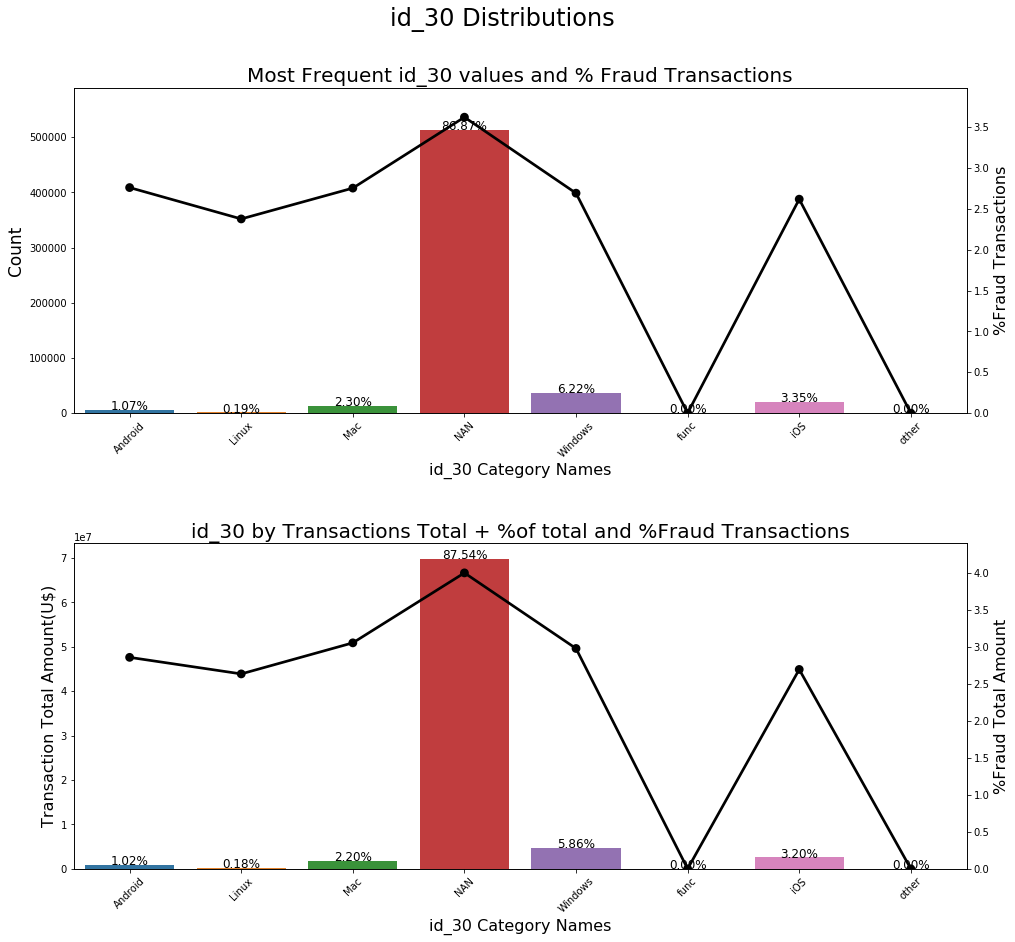

In [0]:
ploting_cnt_amt(df_train, 'id_30')

## Id 31

In [0]:
df_train.loc[df_train['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
df_train.loc[df_train['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
df_train.loc[df_train['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
df_train.loc[df_train['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
df_train.loc[df_train['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
df_train.loc[df_train['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
df_train.loc[df_train['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
df_train['id_31'].fillna("NAN", inplace=True)
df_train.loc[df_train.id_31.isin(df_train.id_31.value_counts()[df_train.id_31.value_counts() < 200].index), 'id_31'] = "Others"

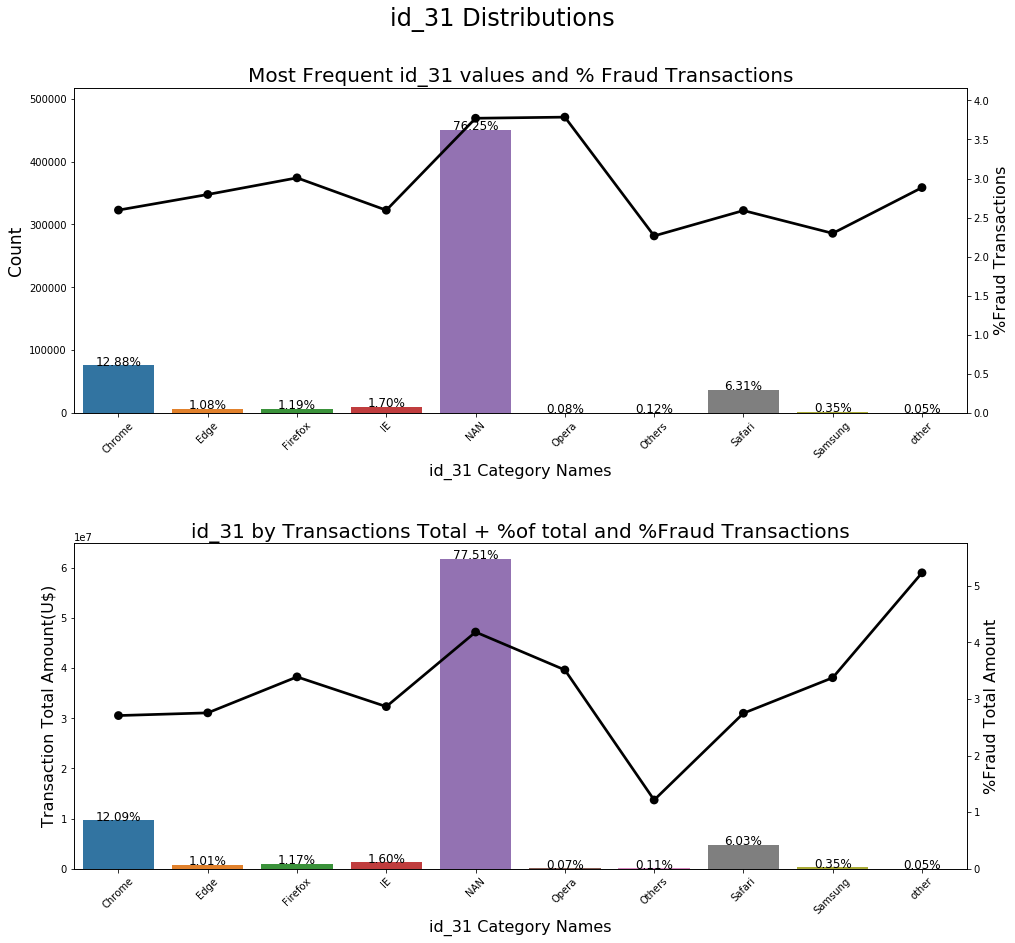

In [0]:
ploting_cnt_amt(df_train, 'id_31')